In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as this lecture is about interpolation we will make use of this SciPy library
import scipy.interpolate as si
import scipy.integrate as integrate

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# 9.1 Interpolation & Quadrature 2 <a class="tocSkip">

Lecture 9.1  
Matt Piggott

## Lecture plan / learning objectives: <a class="tocSkip">


* Review and consolidation of some Computational Mathematics material - I will review quite a lot of key material we saw in that previous module.


* To cover some more advanced topics related to the approximation of data and functions.


* To introduce piecewise-linear basis functions and expansions (an important part of the finite element method).


* To cover some more advanced topics related to the approximation of integrals.


* More exposure to error analysis and convergence rates.


* More practice of your coding skills.


* Introduction to the generic principles of Richardson extrapolation and adaptive algorithms.


## What's really important here? <a class="tocSkip">


- General familiarity with errors and their dependence on the specifics of the numerical method, the function being considered and the interval size (or mesh resolution).


- The specifics of the hat functions used as a basis for p/w linear interpolation.


- Anything with a double star can be completely ignored, including the similarly coloured material within that section.

## Table of Contents

```{contents}
```

## Interpolation 

## Review

Recall that we often wish to approximate data, e.g. in 1D this might be a series of $y$ values at $x$ locations:

$$ (x_i, y_i),\;\;\;\;\;\; i=0,\ldots,N,$$


The data may be known to be exact (e.g. we may wish to approximate a complex function, which we can evaluate exactly, by a simpler expression say), or it may have acknowledged errors from measurement/observational techniques, with known or unknown [error bars](https://en.wikipedia.org/wiki/Error_bar).

<br>


[*Interpolation*](https://en.wikipedia.org/wiki/Interpolation) generally assumes that these data points are *exact* (e.g. no measurement errors) and at *distinct* $x$ locations, i.e. there is no ambiguity in a mapping from $x$ to $y$ (which there would be if we had multiple $y$ values for the same $x$; we will see this scenario in the case of curve-fitting covered below. The same $x$ and $y$ pairs exactly repeated obviously means repeated data and depending on application all the exact replicas might be removed). 

<br>

The requirement for distinct $x$ locations means that we have a constraint on the $x_i$'s which can be written as

$$x_0 < x_1 < \ldots < x_N,$$ 

[Note that sometimes we may have control over the $x$ locations, but sometimes we won't - we'll just be given arbitrary data - we'll cover both cases below].

<br>

The process of interpolation involves finding the function $f$ such that 

$$y_i = f(x_i),\;\;\;\;\;\; \forall i$$


and recall that we have a lot of choice for how we construct the interpolating or curve-fitting function $f$.



#### Some arbitrary test data

Let's first invent a small set of arbitrary data which we shall seek to interpolate throughout this lecture using different methods, and define a function that will save us from typing the same plotting commands multiple times.

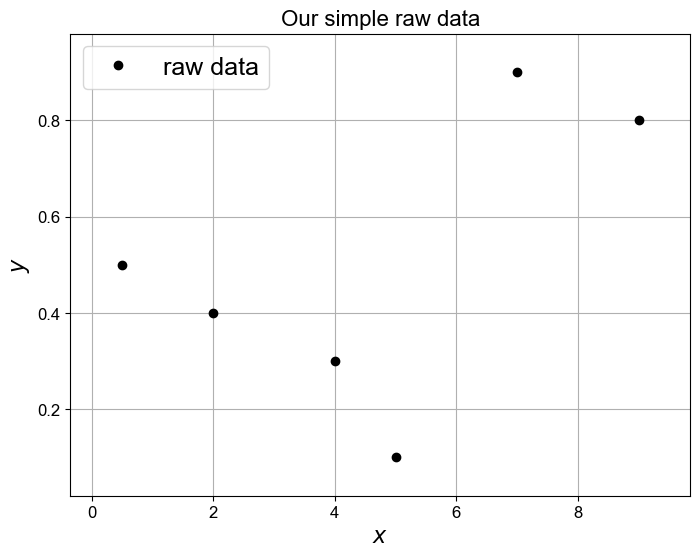

In [2]:
# Invent some raw data - we will use the notation (xi,yi) for the
# given data, where xi and yi are of length N+1 (N=len(xi)-1)
xi = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# We will want to overlay a plot of the raw data a few times below so 
# let's do this via a function that we can call repeatedly
# [Note that I've been a bit lazy in later lectures and really should
# do this sort of thing more often to make code easier to read - apologies]
def plot_raw_data(xi, yi, ax):
    """plot x vs y on axes ax, 
    add axes labels and turn on grid
    """
    ax.plot(xi, yi, 'ko', label='raw data')
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.grid(True)


# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

# For clarity we are going to add a small margin to all the plots.
ax1.margins(0.1)

# plot the raw data
plot_raw_data(xi, yi, ax1)

# add a figure title
ax1.set_title('Our simple raw data', fontsize=16)

# Add a legend
ax1.legend(loc='upper left', fontsize=18);
# loc='best' means we let matplotlib decide the best place for the
# legend to go.  For other options see 
#  https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html

#### Simple interpolation example

One of the simplest examples of interpolation is to simply fit a straight line between every two successive data points.

This is termed **piecewise-linear** interpolation, and the resulting function is called a **piecewise-linear interpolant**.

This is an example of the more general **piecewise-polynomial** interpolation - a piecewise quadratic discontinuous function was given in the example image above.

[Note that we will return to piecewise polynomial interpolation a bit later.]

Of course the default approach to plotting effectively performs piecewise-linear interpolation as we shall now see.

In [ ]:
# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

# Plot a piecewise-linear approximation.
# We get this simply by connecting the points with straight lines
# and this is the default behaviour of the plotting routine so simply
# involves a call to 'plot' with our data.
ax1.plot(xi, yi, 'b', label='p/w linear interpolant')

# Overlay raw data
plot_raw_data(xi, yi, ax1)

# Add a legend
ax1.legend(loc='best', fontsize=18)

# add a figure title
ax1.set_title('Raw data and its p/w linear interpolant', fontsize=16);

## Polynomial interpolation (revisited)

### Introduction

Recall that given a set of $N+1$ data points $(x_i, y_i)$ (with distinct $x_i$'s). 

We can use these $N+1$ pieces of distinct information to construct a polynomial with $N+1$ free parameters, i.e. a polynomial of degree $N$:

$$ P_N(x) := \alpha_0 + \alpha_1 x + \alpha_2 x^2 + \alpha_3 x^3 + \ldots \alpha_N x^N, $$

where $\alpha_0, \, \alpha_1, \, \ldots, \, \alpha_N$ are the coefficients of our polynomial. 

<br>

<br>

The exact matching of the number of pieces of distinct data with the number of free parameters tells us that 

<br>

>**The interpolating polynomial of the least degree is unique.**


### Expansion over basis functions (e.g. monomials)

Note that we can also interpret the polynomial interpolant above as a *linear combination* of a <a href="https://en.wikipedia.org/wiki/Basis_(linear_algebra)">*basis*</a> made up of single-term polynomials: 

$$1, \; x, \; x^2, \; \ldots, \; x^N.$$ 

These single term polynomials are also referred to as [*monomials*](https://en.wikipedia.org/wiki/Monomial). 

<br>

<br>

More generally we can write our interpolation function $f$ as

$$f(x) = \sum_{i=0}^N \alpha_i \phi_i(x) $$

where 

- $\alpha_i$ for $i=0,\,\ldots, N$ are the finite number of *weights* we need to find. 


- $\phi_i(x)$ for $i=0,\,\ldots, N$ are a finite number of prescribed *basis functions* 

<br>

For the polynomial interpolation we are currently considering $\phi_i(x) = x^i$ of course. 



### Example

Recall the naive way of recovering the coefficients in polynomial interpolation ...

in the case of three data points where we seek to find a quadratic function, substituting the data into the quadratic yields three linear equations which we can write as the linear system

$$
\begin{pmatrix}
1 & x_0 & x_0^2 \\
1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2
\end{pmatrix}
\begin{pmatrix}
\alpha_0\\
\alpha_1\\
\alpha_2
\end{pmatrix}
=
\begin{pmatrix}
y_0\\
y_1\\
y_2
\end{pmatrix} \;\;\;\;\;\;\;\text{or equivalently in matrix notation} \;\;\;\;\;\; V\boldsymbol{\alpha} =\boldsymbol{y}.
$$

If we solve this system by inverting the matrix ($V$) we have our quadratic polynomial coefficients:  $\boldsymbol{\alpha} = V^{-1}\boldsymbol{y}$.


In [ ]:
# three data point example
xi = [0.3, 0.5, 0.8]
yi = [0.2, 0.8, 0.6]

# use a function to construct the matrix above
# note than numpy already has a function to do this
V = np.vander(xi, increasing=True)


print('V = \n{}'.format(V))

# use a numpy linear algebra solver to solve the system
a = np.linalg.solve(V, yi)

# output the coefficients for our quadratic we have computed
print('\n Our coefficients a = \n{}\n'.format(a))

# show that they are the same as is obtained from 
# numpy's polyfit function (for a quadratic)
# (which of course they should be, given we argued that this polynomial is unique)
print('The output from np.polyfit(x, y, 2) = \n {}'.format(np.polyfit(xi, yi, 2)))

# Note that the order is reversed because numpy.poly* assumes decreasing
# rather than the increasing powers of x which we have used above

# set up figure
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)

# plot the raw data
plot_raw_data(xi, yi, ax1)

# x locations at which to evaluate and plot the quadratic polynomial
x = np.linspace(0., 1., 100)

# Set up a polynomial from the coefficients using numpy rather than writing out.
# Use numpy.flip to reverse the coefficients as poly1d assume decreasing rather than
# increasing powers - look at documentation
p2 = np.poly1d(np.flip(a, 0))
print('\nWhich agrees with us as long as we reverse the order of our coefficients:')
print('np.flip(a, 0) = \n{}'.format(np.flip(a, 0)))

# the p2 here is a function so evaluate it at our x locations
y = p2(x)

# and plot
ax1.plot(x, y, 'b', label='Quadratic')

# add a figure title
ax1.set_title('Polynomial approx to three data points', fontsize=16)
# Add a legend
ax1.legend(loc='best', fontsize=14)
# set bounds
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

### Lagrange polynomial 

Recall that we asked the question previously - can we do better?

Can we avoid the need to form and invert a linear system to find our coefficient?

The answer was yes and the [Lagrange polynomial](http://mathworld.wolfram.com/LagrangeInterpolatingPolynomial.html) was a method to do this that required us to select a better set of basis functions.

<br>

Given a set of $(N+1)$ points as above, the Lagrange polynomial is defined as the linear combination

$$L(x) := \sum_{i=0}^{N} y_i \ell_i(x),$$

where the $\ell_i(x)$ are a new choice for our basis functions known as the *Lagrange basis polynomials* and are defined by the product

$$\ell_i(x) := \prod_{\begin{smallmatrix}0\le m\le N\\ m\neq i\end{smallmatrix}} \frac{x-x_m}{x_i-x_m} = \frac{(x-x_0)}{(x_i-x_0)} \cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})} \frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_N)}{(x_i-x_N)},$$

where $0\le i\le N$,

and the $y_i$ are the $N+1$ weights/coefficients corresponding to this basis.

<br>

Uniqueness of the interpolating polynomial of minimum degree means that the result from the use of monomials of Lagrange basis polynomials means that both approaches yield identical interpolating polynomials.

For example, let's use this polynomial

$$f(x) = P_N(x) = 2 + 3x + 4x^2$$ 

to evaluate some $y$ values for three equally spaced $x$ values:

we thus have the $(x,y)$ data pairs $(0,2)$, $(1,9)$, $(2,24)$.

<br>


The Lagrange polynomial can be immediately written down:


$$
\begin{align*}L(x) & = 2 \ell_0(x) + 9  \ell_1(x) + 24 \ell_2(x) \\[20pt]
&= 2\frac{(x-1)}{(0-1)}\frac{(x-2)}{(0-2)} 
+ 9\frac{(x-0)}{(1-0)}\frac{(x-2)}{(1-2)} 
+ 24\frac{(x-0)}{(2-0)}\frac{(x-1)}{(2-1)}
\end{align*} 
$$

and either by expanding and collecting terms, of visually, we can establish that this is identical to the original function.

[We'll come back to this example and expansion a bit later].

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
x = np.linspace(0,2,100)

P = 2. + 3. * x + 4. * x**2

L = 2. * (x-1)/(0-1) * (x-2)/(0-2) \
+ 9 * (x-0)/(1-0) * (x-2)/(1-2) \
+ 24 * (x-0)/(2-0) * (x-1)/(2-1)

ax1.plot(x, P, 'b', label='$P_N(x)$')
ax1.plot(x, L, 'r.', label='$L(x)$')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Compare two polynomial approximations', fontsize=16)
ax1.legend(loc='best', fontsize=16)

## Using scipy.interpolate

Recall that we can use [scipy.interpolate.lagrange](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)
from Python's [SciPy](http://www.scipy.org) library to generate the Lagrange polynomial.

First our three point example.

In [ ]:
### Our raw data from earlier - you can also test on our three data point example
xi = np.array([0,1,2])
yi = np.array([2,9,24])

# Create the Lagrange polynomial for the given points.
lp = si.lagrange(xi, yi)
# recall above that we executed 'import scipy.interpolate as si'
# and so this line is calling the 'lagrange' function from the 
# 'interpolate' sub-package within scipy.

# Evaluate this function at a high resolution (100 points here) so that 
# we get a smooth well-resolved line when we plot our polynomial
x = np.linspace(-0.5, 2.5, 100)

# set up the figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

# actually plot (x,y)=(x,lp(x)) on the axes with the label ax1
ax1.plot(x, lp(x), 'b', label='Lagrange interpolating polynomial')

# Overlay raw data on the same axes
plot_raw_data(xi, yi, ax1)
ax1.set_title('Lagrange interpolating polynomial (SciPy)', fontsize=16)

# Add a legend
ax1.legend(loc='best', fontsize=14);

and our larger data set from earlier

In [ ]:
### Our raw data from earlier - you can also test on our three data point example
xi = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# Create the Lagrange polynomial for the given points.
lp = si.lagrange(xi, yi)
# recall above that we executed 'import scipy.interpolate as si'
# and so this line is calling the 'lagrange' function from the 
# 'interpolate' sub-package within scipy.

# Evaluate this function at a high resolution (100 points here) so that 
# we get a smooth well-resolved line when we plot our polynomial
x = np.linspace(0.4, 9.1, 100)

# set up the figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

# actually plot (x,y)=(x,lp(x)) on the axes with the label ax1
ax1.plot(x, lp(x), 'b', label='Lagrange interpolating polynomial')

# Overlay raw data on the same axes
plot_raw_data(xi, yi, ax1)
ax1.set_title('Lagrange interpolating polynomial (SciPy)', fontsize=16)

# Add a legend
ax1.legend(loc='best', fontsize=14);

An implementation of the Lagrange basis functions and thus the Lagrange polynomial was a homework exercise when we considered interpolation in the Computational Mathematics module.

It turns out that there is yet another way of writing the (unique) interpolating polynomial that results in an algorithm that is arguable easier to implement - this is termed the Newton polynomial.


## Newton polynomial  [$\star$]

```{toggle} Optional Content
:show:
Calculating the Newton polynomial (also called [Newton's divided difference interpolation polynomial](http://mathworld.wolfram.com/NewtonsDividedDifferenceInterpolationFormula.html)) yields the same polynomial as the Lagrange polynomial method (remember that the polynomial of minimum degree to pass through each data point is unique), but is arguably easier to implement (and this implementation is a useful coding exercise - see homework).

<br>

To derive this approach we write our degree $N$ polynomial in the following form


$$ P_N(x) = a_0 +(x-x_0)a_1 + (x-x_0)(x-x_1)a_2 + \cdots + \left[(x-x_0)(x-x_1)\ldots(x-x_{N-1})\right]a_N,$$


note that this is indeed a degree $N$ polynomial and as before was have $N+1$ free parameters  $a_0, a_1, \ldots, a_N$, which we need to find using the $N+1$ pieces of information we have in the given data.




Efficient derivation of an algorithm to compute the Newton polynomial follows from noticing that we can write this polynomial in a <a href="https://en.wikipedia.org/wiki/Recursion_(computer_science)">*recursive form*</a>.  

Consider for example a case with $N=3$:

$$
\begin{align}
P_3(x) &= a_0 +(x-x_0)a_1 + (x-x_0)(x-x_1)a_2 + (x-x_0)(x-x_1)(x-x_2)a_3\\[5pt]
&= a_0 +(x-x_0)[a_1 + (x-x_1)[a_2 + (x-x_2)a_3]].
\end{align}
$$

Notice that substituting in the $x_i$ values leads to a set of simultaneous equations where we can easily evaluate the unknowns $a_0, a_1, \ldots$ using what is termed 'back (or forward) substitution'.  

We'll see an example of this now ...



1. Substitute $x=x_0$: We have $a_0 = P_3(x_0)$, and we know that our interpolant $P_3(x)$ evaluated at $x_0$ must return $y_0$. Hence, 

<br>
    
$$a_0 = y_0.$$

<br>

    
2. Now substitute $x=x_1$: We have $P_3(x_1) = a_0 +(x_1-x_0)a_1 = y_0 +(x_1-x_0)a_1 $, the LHS of this is $y_1$, and we know everything on the RHS as we have already calculated $a_0 = y_0$. We can thus trivially rearrange to yield

<br>

$$ a_1 = \frac{(y_1 - y_0)}{(x_1-x_0)}.$$

<br>

3. Substituting $x=x_2$ yields 

<br>

$$
\begin{align*}
& y_2 = P_3(x_2) = a_0 +(x_2-x_0)[a_1 + (x_2-x_1)a_2] = y_0 + (x_2-x_0)\left[ \frac{(y_1 - y_0)}{(x_1-x_0)} + (x_2-x_1)a_2\right]\\[5pt]
&\implies a_2 = \frac{ \frac{(y_2 - y_0)}{(x_2-x_0)} - \frac{(y_1 - y_0)}{(x_1-x_0)}}{x_2-x_1}.
\end{align*}
$$

<br>

4. And so on ...




    
To define an algorithm for this method in general let's first introducing the following [*divided difference*](https://en.wikipedia.org/wiki/Divided_differences) notation

$$
\begin{alignat*}{2}
\Delta y_i &= \frac{y_i-y_0}{x_i-x_0},\;\;    && i=1,2,\ldots, N,\\[10pt]
\Delta^2 y_i &= \frac{\Delta y_i-\Delta y_1}{x_i-x_1},\;\;    && i=2, 3,\ldots, N,\\[10pt]
&\vdots\\[5pt]
\Delta^N y_N &= \frac{\Delta^{N-1} y_N-\Delta^{N-1} y_{N-1}}{x_N-x_{N-1}}.
\end{alignat*}
$$

With a bit of thought we can hopefully see from the above example that the coefficients of the interpolating polynomial in the general case are given by


$$a_0=y_0,\;\;\;\;\; a_1 = \Delta y_1, \;\;\;\;\; a_2 = \Delta^2 y_2, \;\;\;\;\; \ldots \;\;\;\;\; a_N = \Delta^N y_N.$$


See the homework exercise for an implementation of functions to construct and evaluate the Newton polynomial.
```


##  Approximating a function

Rather than approximating/interpolating arbitrary discrete data given to us somehow (e.g. from observations, or from a very expensive computer code which has been run previously), we can of course use the same methods to approximate a given function. 

We may want to do this in order to approximate a complex/expensive function with a simpler, cheaper interpolating function.

Our "function" may be a large expensive PDE solver for example.

<br>

Note that to avoid confusion I will use $f$ as the given function we wish to approximate and $f_h$ as the interpolating function.

## A simple example

For example, consider the function $y(x)=x^3$ with data provided at  equally spaced points.  

Let's see what happens if we evaluate with Lagrange polynomials of degree 0, 1 and 2.

[Note that since in this case we are given the underlying function, we can in principle choose the locations and number of data points, so for the degree 0, 1 and 2 Lagrange polynomials we first need to evaluate the underlying function 1, 2 and 3 times respectively. For simplicity below we just choose these to be evenly distributed in our $x$ domain of interest].

In [ ]:
# this is the function we are going to approximate with low degree polynomials
def func_x3(x):
    return x**3

# as we will plot our approximation several times let's write a small function to do this
def plot_approximation(f, xi, ax):
    """Function that plots an original function and its Lagrange polynomial approximation. 

    Parameters
    ----------
    f : callable
        Original function
    xi : array_like
        The x-component of the data
    ax : matplotlib axes
        The axes to plot on
    """
    # Relatively fine x points for plotting our functions
    x = np.linspace(0.5, 3.5, 100)
    # Plot the original function
    ax.plot(x, f(x), 'k', label = 'Original function')

    # construct and plot the Lagrange polynomial
    lp = si.lagrange(xi, f(xi))
    # evaluate and plot the Lagrange polynomial at the x points
    ax.plot(x, lp(x), 'b', label = 'Lagrange poly. interpolant')

    # shade the region between the two to emphasise the difference
    ax.fill_between(x, f(x), lp(x))

    # add some axis labels
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$f(x), \; P_N(x)$', fontsize=14)

    # and add on top the interpolation points
    ax.plot(xi, f(xi), 'ko')

    # and a legend
    ax.legend(loc='best', fontsize=13)


# set up our figs for plotting - we want three subplots arranged in a 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# add some padding otherwise axes the labels can overlap with the next subplot
fig.tight_layout(w_pad=4) 

# Plot the L0 degree 0 Lagrange poly and visualise the error
plot_approximation(func_x3, np.array([2., ]), ax1)
ax1.set_title('Approximating a cubic with a constant', fontsize=16)

# Plot the L1 degree 1 Lagrange poly and visualise the error
plot_approximation(func_x3, np.array([1., 3.]), ax2)
ax2.set_title('Approximating a cubic with a linear', fontsize=16)

# Plot the L2 degree 2 Lagrange poly and visualise the error
plot_approximation(func_x3, np.array([1., 2., 3.]), ax3)
ax3.set_title('Approximating a cubic with a quadratic', fontsize=16);

## Error in Lagrange interpolation

Note that it can be proven that in the case where we are interpolating a known function (e.g. a complicated non-polynomial function such as $\exp$ or $\sin$) by a simpler polynomial, the error at any point we evaluate the interpolant at is proportional to:


- (1) the distance of that point from any of the data points (which makes sense as the error is obviously zero at the data points),


- (2) and to the $(N+1)$-th derivative of that function evaluated at *some* location within the bounds of the data.  


i.e. the more complicated (sharply varying) the function is, the higher the error *could* be.

Note the similarities here with the Taylor series expansion.

This result is sometimes called the [*Lagrange remainder theorem*](https://en.wikipedia.org/wiki/Polynomial_interpolation#Interpolation_error).

We won't prove this here, but it will be useful in later lectures if we write it down now.


    
### Aside: The Lagrange Remainder Theorem  [$\star$]
```{toggle} Optional Content
:show:
For $N\ge 0$, let $f(x)$ be a function with at least $N+1$ continuous derivatives over the interval $[a,b]$, 

(the mathematical way of writing this is $f \in C^{N+1}[a,b]$ - see [http://mathworld.wolfram.com/C-kFunction.html](http://mathworld.wolfram.com/C-kFunction.html) for more details on this if interested) 

and let $\;\;x_0<x_1<\ldots<x_N\;\;$ be $N+1$ distinct points in $[a,b]$. 

Then the degree ($\le$) $N$ polynomial interpolating $f(x)$ at these points, $P_N(x)$, satisfies


$$ f(x) = P_N(x) + R_N(x) \;\;\;\;\;\; \text{or} \;\;\;\;\;\; R_N(x) = f(x) - P_N(x) \;\;\;\;\;\; \forall x\in[a,b],$$


where $R_N(x)$ is the *remainder*, or the [*interpolation error*](https://en.wikipedia.org/wiki/Polynomial_interpolation#Interpolation_error), and takes the form

$$
\begin{align*} 
R_N(x) & = \frac{(x-x_0)(x-x_1)\cdots(x-x_N)}{(N+1)!} \, f^{(N+1)}(c_x) \\[10pt]
& = \Psi_N(x)\,\frac{f^{(N+1)}(c_x)}{(N+1)!},
\end{align*}
$$

where $c_x$ is *some* value/point/location between the maximum and minimum values of $x_0, \ldots, x_N$ and $x$,

and where 

$$ \Psi_N(x) := \prod^N_{i=0} (x - x_i) = (x-x_0)(x-x_1)\cdots(x-x_N). $$


<br>

This gives us an expression for the error, but we don't know what $c_x$ is and so it's not that helpful.  


<br>


**However, we can use this result to derive an upper bound on the error:**




    
If you want you can think of the unknown $c_x$ as being some value $c_x \in (a,b)$, and by setting 

$$M:=\max_{x\in(a,b)}\, \left| f^{(N+1)}(x) \right|,$$ 

i.e. defining $M$ to be the *maximum* value of the ($N+1$)-th derivative over our interval, 


<br>



then we are left with the error **bound** that no longer depends on this unknown $c_x$:


<br>


$$
\boxed{
\left| f(x) - P_N(x) \right| \le \frac{1}{(N+1)!}\, M\, \left|\Psi_N(x)\right|,  \\[20pt]
M:=\max_{x\in(a,b)}\, \left| f^{(N+1)}(x) \right|, \\
\Psi_N(x) := \prod^N_{i=0} (x - x_i) = (x-x_0)(x-x_1)\cdots(x-x_N).
}
$$
```


    
### Observations  [$\star$]
```{toggle} Optional Content
:show:
This looks complicated, but we can make multiple observations based on this quite easily
(some which just reinforce things that are obvious, or that we have seen already):


<br>

- (1) The error is zero at the nodes (as $\Psi_N(x)$ vanishes at these points).

<br>

- (2) The error is zero everywhere if $f$ is a polynomial of degree $N$ or less (as then $f^{N+1}(x)\equiv 0$), which is of course equivalent to saying that we can approximate a given polynomial function exactly if we match degrees.

<br>

- (3) This result is only true for smooth functions and essentially says that smooth functions behave like polynomials (cf. a truncated [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) expansion) - this is why polynomial interpolation works for smooth functions.

<br>

- (4) However, this mathematical result (and hence all of our observations based on it) are invalid when $f$ has discontinuous derivatives (is not smooth) - because $f$ no longer behaves like a polynomial (e.g. it can do what it likes between the known points).

<br>

- (5) Functions with larger $(N+1)$-st derivative will tend to have larger interpolation errors.

<br>

- (6) For a given function $f$, minimising the interpolation error for a given choice on $N$ is effectively the same as minimising $\left|\Psi_N(x)\right|$ for $x\in [a,b]$.  In addition, the structure of the error (i.e. how it varies in space) is due to the spatial structure of $\Psi$ (as the other terms do not depend on $x$).

<br>

The final point is important - we will return to this shortly.
```




### Example  [$\star$]
```{toggle} Optional Content
:show:
What does this tell us for our example $f(x)=x^3$?

As for our plots above with this example, let's assume $[a,b]=[0.5, 3.5]$ and compute the error (estimate or bound) based upon the above theory.

We need the maximum value of the appropriate (i.e. dependent on our polynomial degree) degree derivative over the interval:

$$
\begin{align*}
N & = 0: \;\;\;\; & \max_{x\in(a,b)}f'(x) & = \left. 3x^2 \right|_{x = 3.5} = 36.75,\\[15pt]
N & = 1: \;\;\;\; & \max_{x\in(a,b)}f''(x) & = \left. 6x \right|_{x = 3.5} = 21,\\[15pt]
N & = 2: \;\;\;\; & \max_{x\in(a,b)}f'''(x) & =  6, \\[15pt]
N & = 3: \;\;\;\; & \max_{x\in(a,b)}f^{(4)}(x) & = 0. 
\end{align*}
$$

Let's now evaluate the actual error between the function and the interpolating polynomials and see how well these error estimates agree, or bound this error.
```

In [ ]:
from math import factorial

def func_x3(x):
    return x**3

def plot_errors(f, xi, ax):   
    N = len(xi) - 1

    # M contains the maximum derivative values, as computed above;
    # a component (the N-th) of which appear as one factor in our error estimate.
    M = [36.75, 21., 6.]

    # for the approximation with a Lagrange polynomial
    lp = si.lagrange(xi, f(xi))

    # plot the error between the function f(x) and the Lagrange polynomial over [0.5,3.5]
    x = np.linspace(0.5, 3.5, 1000)
    ax.plot(x, np.abs(f(x) - lp(x)), 'b', label = 'Error - actual')

    # compute the Psi function defined above, here using "list comprehension"
    Psi = np.prod([(x - xi[i]) for i in range(N+1)], axis=0)

    # our error estimate is (1/(N+1)!) * M * |Psi|.  Plot this:
    ax.plot(x, (1./factorial(N+1)) * M[N] * np.abs(Psi), 'r--', label = 'Error bound estimate')

    # add labels and legend
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
# set up our figs for plotting - we want three subplots arranged in a 1x3 grid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.tight_layout(w_pad=4)  # add some padding otherwise axes labels overlap

# L0
plot_errors(func_x3, np.array([2., ]), ax1)
ax1.set_title('Theoretical vs exact error - constant', fontsize=16)

# L1
plot_errors(func_x3, np.array([1., 3.]), ax2)
ax2.set_title('Theoretical vs exact error - linear', fontsize=16)

# L2
plot_errors(func_x3, np.array([1., 2., 3.]), ax3)
ax3.set_title('Theoretical vs exact error - quadratic', fontsize=16);



### Comments  [$\star$]
```{toggle} Optional Content
:show:
1. Our error bound is indeed an **upper bound** on the actual error.


2. Both the actual error and the error bound are zero at the data locations. 


3. For this example (i.e. a 'simple' cubic function), our error bound is actually exactly equal to the real error in the case of the quadratic approximation - why is this?


<br>

[When an error bound value is very close to the actual error we call it a *tight* bound - tighter bounds are obviously more useful in practice although not always necessary for proving theoretical results - <https://en.wikipedia.org/wiki/Upper_and_lower_bounds>].
```




## A more problematic example [$\star$]
```{toggle} Optional Content
:show:
[This is an illustrative example to demonstrate how things can go wrong, especially when using high-degree approximating polynomials.]

<br>

Approximating the [Runge function](https://en.wikipedia.org/wiki/Runge%27s_phenomenon):

$$f(x) := \frac{1}{1 + 25 x^2},$$

using equally spaced data points in the interval $[-1,1]$ is a famous example demonstrating how/where polynomial interpolation can go wrong!
```


In [ ]:
# define the runge function
def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def plot_approximation(f, xi, ax):
    """Function to plot exact function f (e.g. Runge) and its Lagrange polynomial approximation.

    Parameters
    ----------
    f : callable
        The Runge function
    xi : array_like
        The x-component of the data
    ax : matplotlib axes
        The axes to plot on
    """
    x = np.linspace(-1.0, 1.0, 100)
    ax.plot(x, f(x), 'k', label='Runge function')

    lp = si.lagrange(xi, f(xi))
    ax.plot(x, lp(x), 'b', label='Poly. approx.')

    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$f(x)$', fontsize=14)


# the problem gets worse at higher degree - list of degrees to consider
degrees = [1, 2, 3, 5, 9, 12, 15, 20]

# set up our figs for plotting
fig, axs = plt.subplots(2, np.int(len(degrees)/2), figsize=(12, 8))
# this turns the 2D array of axes into a 1D vector we can easily call in the loop below
axs = axs.reshape(-1)
# add some padding otherwise axes labels overlap
fig.tight_layout(w_pad=3, h_pad=4)

# enumerate is a useful way to loop over something (here degrees) and have 
# an automatic counter - here i which we use to identify the correct axis
for i, degree in enumerate(degrees):
    xi = np.linspace(-1, 1, degree + 1)
    plot_approximation(runge, xi, axs[i])
    axs[i].plot(xi, runge(xi), 'ko', label='data')
    axs[i].set_title('Degree %i' % degree, fontsize=14)
    axs[i].legend(loc='best', fontsize=12)



### Observations  [$\star$]
```{toggle} Optional Content
:show:

- We see that for this problem, with increasing numbers of evenly spaced data points, the corresponding Lagrange polynomials, while doing a better and better job of approximating the underlying exact function *towards the middle* of the interval, do an increasingly bad job towards the *ends of the interval*.


- **Take home message:**  Try to avoid high-degree interpolants when the data is evenly spaced - as high-degree polynomials have a tendency to oscillate strongly between data points, especially at the ends.


- So interpolation here in regions of the domain would give huge errors. Imagine further what would happen if you tried to use one of these Lagrange polynomials to estimate a value for the Runge function slightly outside the $[-1,1]$ interval considered here (i.e. to **extrapolate**) - the result would clearly be terrible. This is therefore **also** a good example of why extrapolation in general should be undertaken with extreme caution!
```



### An explanation  [$\star$]
```{toggle} Optional Content
:show:
The reason for this behaviour is a consequence of two factors:


- Although smooth, the magnitude of the derivative of this function grows with $N$ [see homework exercise].


- The behaviour of the $\Psi$ quantity is such that, relatively speaking, with evenly spaced data points $\Psi(x)$ is much larger in the outer sub-intervals than it is the middle of the domain - as we can see in the following plot.


One of the homework exercises involves plotting the error bound - and the byproduct of multiplying things together which are very large/small is an error bound which we can indeed show gets very large with $N$ and with the error largest at the end points.
```


In [ ]:
# plot Psi for different N values:
Ns = [0, 1,  5,  20]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.linspace(-1., 1., 1000)
for N in Ns:
    xi = np.linspace(-1, 1, N+1)
    Psi = np.prod([(x - xii) for xii in xi],axis=0)
    ax.plot(x, Psi / max( 1.e-10, np.max(np.abs(Psi)) ), label='N='+str(N) ) 
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$\Psi(x)/\max({\Psi})$', fontsize=14)
    ax.set_title('Relative size of $\Psi$ across our interval', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
N = 20
xi = np.linspace(-1, 1, N+1)
Psi = np.prod([(x - xii) for xii in xi],axis=0)
ax.plot(x, Psi , label='N='+str(N) ) 
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$\Psi(x)$', fontsize=14)
ax.set_title('Absolute size of $\Psi$ across our interval', fontsize=14)
ax.legend(loc='best', fontsize=14);


## Chebyshev nodes  [$\star$]
```{toggle} Optional Content
:show:
There were three components making up the error bound - the factorial of $N+1$, a bound on the $(N+1)$-st derivative of the function, and $\Psi$. For a given function and polynomial degree, we have no control over the first two, but we do have some ability to control the third, and we saw above that the behaviour of $\Psi$ is indeed a problem as $N$ grows.

The above example can be "fixed" (or at least we can attempt to do a better job) by seeking to minimise $\Psi(x)$ over our entire interval (including the outer sub-intervals where above and in the homework we see there's a clear issue).

For a fixed $N$, the only thing we have the ability to change is to choose different $x_i$ data points, i.e. to sample our function at non-uniformly spaced *locations*.

Note that by the definition/construction of $\Psi$, these *locations* are the *roots* of $\Psi$, i.e. the locations where $\Psi$ is zero.


<br>


So said another way, we want to find/select the polynomial $\Psi$ that is smallest over our interval; the optimal sampling data points for our interpolation process will then be the roots of this polynomial. 

It turns out that 
<a href="https://en.wikipedia.org/wiki/Chebyshev_polynomials#Minimal_%E2%88%9E-norm">*Chebyshev polynomials*</a> have this minimal property, and hence our optimal sample points are the roots of these Chebyshev polynomials - since they are so important these points have their own name: [*Chebyshev nodes*](https://en.wikipedia.org/wiki/Chebyshev_nodes).

The Chebyshev nodes in the interval $(-1,1)$ are given by the formula

$$x_i = \cos \left (\frac{2i - 1}{2N}\pi \right ), \;\;\;\; i = 1, \ldots, N,$$

and as we will see in the following example, evaluating our function at these non-uniform locations and using this data to construct our interpolating polynomial fixes the problem we saw above for the case where we used evenly spaced data.

In the next cell we again compute and plot the Lagrange polynomial interpolant for differing $N$, but simply change the location of the data sampling points `xi`. 
```


In [ ]:
# we don't need to consider quite so many cases now to prove the point that
# things have improved substantially.
degrees = [5, 9, 12, 20]

# set up our figs for plotting
fig, ax = plt.subplots(1, len(degrees), figsize=(12, 4))
fig.tight_layout(w_pad=2)  # add some padding otherwise axes labels overlap

for i, degree in enumerate(degrees):
    # use the Chebyshev nodes instead
    xi = np.cos((2.0 * np.arange(1, degree+2) - 1.0) * np.pi / (2.0 * (degree+1)))
    # compute and plot the Lagrange polynomial using Chebyshev nodes as data locations
    plot_approximation(runge, xi, ax[i]) # recall that this function also computes L_p
    ax[i].plot(xi, runge(xi), 'ko', label='data')
    ax[i].set_title('Degree %i' % degree, fontsize=16)
    ax[i].legend(loc='best', fontsize=14)

# add another figure to plot Chebyshev node locations
fig, ax = plt.subplots(1, 1, figsize=(12, 1))
ax.plot(xi, np.zeros_like(xi), 'ko')
ax.yaxis.set_ticks([])
ax.set_xlabel('$x$', fontsize=16)
ax.set_title('Locations of the Chebyshev nodes in the degree 20 case', fontsize=16);


    
We see that rather than being evenly distribute the data points are now clustered towards the extremes of the domain.
    
<br>
    
## Chebyshev polynomial interpolation  [$\star$]
```{toggle} Optional Content
:show:
This in turn leads us to a new set of basis functions which we could use as the basis for our polynomial interpolation.

In the same way that the values of the underlying function at our data point locations were, by construction, the weights for the Lagrange basis functions we defined above, the values of the underlying function at the non-uniform Chebyshev nodes are the weights for an interpolant which uses Chebyshev polynomials as basis functions [see homework exercise].

Summing, the resulting function is called the *Chebyshev polynomial interpolant*.

Chebyshev nodes/interpolation have many nice theoretical properties, which we won't cover here.

Note that the construction of these basis functions is a homework exercise, where the exact details are explained in the question.
```


## Piecewise polynomial interpolation 

An alternative approach to overcome the issues identified above which attempted to fit a *single* *high-degree* polynomial to multiple data points, is to split the data into pieces and fit a lower degree polynomial through each of these.

The piecewise (p/w) linear interpolation we saw near the start of this lecture would of course be an example of this.
    

### Piecewise-linear interpolant

The implementation of piecewise (p/w) linear interpolation would simply take two data points $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$ in turn and fit a linear polynomial between them:


$$P_1^i(x) = \frac{ y_{i+1} - y_i }{ x_{i+1} - x_i }(x - x_i) + y_i,$$


the superscript $i$ is included to emphasise here that we are only considering one (the $i$-th) sub-interval.

This is easy to implement ourselves using this formula; we could reuse our Lagrange interpolation code, or indeed as we saw above simply plotting the data we get this result as well.

Alternatively we could just use the `numpy.polyfit` function to fit the appropriate degree polynomial to the data; we will see more on this below.


### Piecewise-quadratic interpolant

We can extend the linear example above by fitting a quadratic to three data points.

So for every 3 sets of points we fit a quadratic - to keep things simple we therefore require $3+2\times n$ data points, for some integer $n$ (i.e. the first set of three, and then sets of two extra as we reuse the last entry from the previous set of three as the first of the new set).  We therefore need to add a point to our example data set from above to satisfy this constraint.

This time we will make use of `numpy.polyfit` to construct each quadratic for simplicity.

In [ ]:
# Add an extra point to our data so that we have three complete sets of data
xi = np.array([0.5, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.5, 0.3, 0.1, 0.9, 0.8])

# construct the interpolant at these x points for plotting
x = np.linspace(np.min(xi), np.max(xi), 1000)

# initialise the value of our interpolant at x to zero
P2 = np.zeros_like(x)

# loop over collections of three data points from (xi,yi), i is the mid value
for i in range(1, len(xi), 2):
    # use polyfit to construct a local quadratic polynomial fit to data at i-1, i, i+1
    P2_loc = np.polyfit(xi[i - 1:i + 2], yi[i - 1:i + 2], 2)
    # use polyval to evaluate P2_loc at the x values for x in [x_{i-1},x_{i+1}]
    P2 += np.polyval(P2_loc, x) * (x >= xi[i - 1]) * (x <= xi[i + 1])

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)
ax1.plot(xi, yi, 'b', label='p/w linear')
ax1.plot(x, P2, 'r', label='p/w quadratic')
plot_raw_data(xi, yi, ax1)
ax1.set_title('p/w linear and p/w quadratic approximations', fontsize=16)
ax1.legend(loc='best', fontsize=14);


### Observations


- An obvious drawback of this we see from both the p/w linear and p/w quadratic examples above is that we lose *smoothness* - the interpolant now has jumps in its derivative (sharp corners).


- Since the degree two polynomial that fits through three data points is unique, we could also of course have used our Lagrange polynomial code rather than polyfit in the implementation above (ditto the linear case fit to two points). We used polyfit just to demonstrate/practice using other standard Python (NumPy) functions.


- Note that there are p/w interpolating options which preserve smoothness to varying degrees; these include [cubic splines](https://en.wikipedia.org/wiki/Spline_interpolation) and [cubic Hermite polynomials](https://en.wikipedia.org/wiki/Cubic_Hermite_spline) which we will introduce briefly next.
    



## Piecewise-polynomial interpolation via an appropriate set of basis functions


### The idea

Recall that in terms of basis functions ($\phi_i(x)$) we saw above how we can write a polynomial in several different ways.

Can we find an appropriate basis that allows us to represent a piece-wise polynomial?

Note that this is a vital step in the finite element method which we shall return to in a later lecture.

<br>

Let's consider the expansion of our interpolating function from earlier:

$$f(x) = \sum_{i=0}^N \alpha_i \phi_i(x), $$

what are the basis functions $\phi_i(x)$ that recreate the piecewise linear interpolant?

<br>

A key observation is that with piecewise polynomials, linear say, it's only the local data values that determine the behaviour of the interpolant in between the data points. 

<br>

Note that with monomials, Lagrange basis functions etc, they are defined and have values at all $x$ values, and hence a single data point value and its corresponding basis function influences the interpolant everywhere 

(although as we will see shortly, we can if we wish specify our basis functions to be zero almost everywhere, in which case this observation is no longer true).


### Example - revisiting a quadratic example we've already seen

E.g. for our earlier example quadratic function $P(x)$ we can consider each of the three monomial and Lagrange basis polynomials individually over the interval covered by three data points and demonstrate that with the correctly chosen weights we recover $p$.

For completeness, we also demonstrate this for the Newton polynomial expansion ...

In [ ]:
# First let's demonstrate how to build up our desired quadratic poly using
# monomial basis functions.
# The weights here are given by the known polynomial coefficients, i.e. 2, 3, 4
# while the basis functions are the constant (1), the linear (x) and the quadratic (x**2)

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
fig.tight_layout(w_pad=2)  

x = np.linspace(0,2,100)

P = 2. + 3. * x + 4. * x**2

p0 =  np.ones_like(x)
p1 =  x
p2 =  x**2

ax[0].plot(x, p0, 'r'); ax[0].set_title('$p_0=1$', fontsize=14)
ax[1].plot(x, p1, 'r'); ax[1].set_title('$p_1=x$', fontsize=14)
ax[2].plot(x, p2, 'r'); ax[2].set_title('$p_2=x^2$', fontsize=14)
ax[3].plot(x, 2*p0 + 3*p1 + 4*p2, 'r.', label=r'$\sum \alpha_i p_i(x)$')
ax[3].set_title(r'P vs $\sum \alpha_i p_i(x)$', fontsize=14)
ax[3].plot(x, P, 'b', label='$P(x)$')
ax[3].legend(loc='best', fontsize=16)

In [ ]:
# now let's use an expansion over the Lagrange basis functions
# We know that the Lagrange basis functions are chosen specially
# so that the corresponding weights are the data points, i.e. here
# alpha_i = P(x_i), with x_i = 0, 1, and 2 - this gives weights
# 2, 9 and 24.
# The basis functions are this time each quadratics - 
# but they special quadratics # that are one at one x location, and zero at the other two:

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
fig.tight_layout(w_pad=2)  

x = np.linspace(0,2,100)

P = 2. + 3. * x + 4. * x**2

l0 =  (x-1)/(0-1) * (x-2)/(0-2) 
l1 =  (x-0)/(1-0) * (x-2)/(1-2) 
l2 =  (x-0)/(2-0) * (x-1)/(2-1)

ax[0].plot(x, l0, 'r'); ax[0].set_title('$\ell_0(x)$', fontsize=14)
ax[0].plot([0,2], [0,0], 'b--')
ax[1].plot(x, l1, 'r'); ax[1].set_title('$\ell_1(x)$', fontsize=14)
ax[1].plot([0,2], [0,0], 'b--')
ax[2].plot(x, l2, 'r'); ax[2].set_title('$\ell_2(x)$', fontsize=14)
ax[2].plot([0,2], [0,0], 'b--')
ax[3].plot(x, 2*l0 + 9*l1 + 24*l2, 'r.', label='$L(x)$'); ax[3].set_title('P vs L', fontsize=14)
ax[3].plot(x, P, 'b', label='$P(x)$')
ax[3].legend(loc='best', fontsize=16)

In [ ]:
# now in the case of the Newton polynomial, for completeness
# The basis functions are really just shifted versions of the monomial case,
# and the weights are then known from the above formula

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
fig.tight_layout(w_pad=2)  

x = np.linspace(0,2,100)

P = 2. + 3. * x + 4. * x**2

n0 =  np.ones_like(x) 
n1 =  (x-0)
n2 =  (x-0)*(x-1)

a0 = 2 # y0
a1 = (9-2)/(1-0) # (y1-y0)/(x1-x0)
a2 = ((24-2)/(2-0) - (9-2)/(1-0)) / (2-1) # ((y2-y0)/(x2-x0) - (y1-y0)/(x1-x0)) / (x2-x1)

ax[0].plot(x, n0, 'r'); ax[0].set_title('$n_0(x)$', fontsize=14)
ax[1].plot(x, n1, 'r'); ax[1].set_title('$n_1(x)$', fontsize=14)
ax[2].plot(x, n2, 'r'); ax[2].set_title('$n_2(x)$', fontsize=14)
ax[3].plot(x, a0*n0 + a1*n1 + a2*n2, 'r.', label='$N(x)$'); ax[3].set_title('P vs N', fontsize=14)
ax[3].plot(x, P, 'b', label='$P(x)$')
ax[3].legend(loc='best', fontsize=16)

### Hat functions and p/w linear interpolation/expansions

For p/w linear interpolants with a bit of thought we can come up with some appropriate basis functions, which only contribute to the full interpolant locally.

<br>

These are

$$
\phi_i(x) = 
\begin{cases}
\frac{x - x_{i-1}}{\Delta x_{i-1}}, &\text{if}\;\;\; x\in e_{i-1}\equiv[x_{i-1},x_{i}] \\[5pt]
\frac{x_{i+1} - x}{\Delta x_{i}}, &\text{if}\;\;\; x\in e_{i}\equiv[x_{i},x_{i+1}] \\[5pt]
0, & \text{otherwise} \\
\end{cases}
$$

<br>

which have the name hat (or chapeau) functions, and look like the following.

```{figure} Figures/fem_basis_functions.svg
:width: 75%
```



### Some code to return the hat/basis functions

Let's implement a function that returns the $i$-th hat function on a mesh.  You can try playing with the value for $i$ and seeing how it changes the plot - this code should work find if you don't have uniform x spacing.

In [ ]:
def hat_function(i, x_nodes):
    """ Linear continuous basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

# let's plot what this function returns
# first set up the nodes, a fine mesh to use to plot and the axes
x_nodes = np.linspace(0,1,8)
x_fine = np.linspace(0,1,1000)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(111)
ax1.set_xticks((x_nodes))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$' ), fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('P1 basis function', fontsize=16)

# you can change the following to be in [0,n] to change what the 
# function returns for a given node number
node = 2
phi = hat_function(node, x_nodes)
# it's returned a function phi, so just evaluate this on the mesh
ax1.plot(x_fine, phi(x_fine), 'k-');

To see that this does what we want in terms of delivering p/w linear interpolation let's add two of these basis functions


Let's assume our $(x,y)$ data is $(x_3,4)$ and $(x_4,7)$

In [ ]:
# let's plot what this function returns
# first set up the nodes, a fine mesh to use to plot and the axes
x_nodes = np.linspace(0,1,8)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(111)
ax1.set_xticks((x_nodes))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$','$x_4$','$x_5$','$x_6$','$x_7$' ), fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('P1 basis function', fontsize=16)

phi_l = hat_function(3, x_nodes)
phi_r = hat_function(4, x_nodes)

# plot on a fine mesh, only between the considered $x$ locations [3,4]
x_fine = np.linspace(x_nodes[3],x_nodes[4],1000)

ax1.plot(x_fine, 4*phi_l(x_fine) + 7*phi_r(x_fine), 'k-')
ax1.plot([x_nodes[3],x_nodes[4]],[4,7], 'ro');

So we see that when only considered between the data point locations, we indeed have the correct linear - what does this interpolant do outside these data points?

Now let's use our basis functions to construct the piecewise linear function $f_h(x)$, where the required weights are just given by the function $f$ evaluates at the node locations (`y_nodes = f(x_nodes)`), for a more complex $f$ function.

In this implementation our function returns the values of $f_h(x)$ at a prescribed array of $x$ locations.

In [ ]:
# start from an arbitrary function we wish to approximate/interpolate
def f(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

# discrete data
N_nodes = 4
# if we have 4 nodes, including at the ends of our domain, then we have 4-1=3 elements/cells
N_elements = N_nodes - 1
# and the element size is the total interval length divided by the number of elements
dx = 1./N_elements
# construct the node locations
x_nodes = np.linspace(0., 1., N_nodes)

# and evaluate our function at these points - these will be our weights
y_nodes = f(x_nodes)

# now a function to reconstruct the p/w linear function
def pwlinear(x_nodes, y_nodes, x):
    """Function to return f_h(x) at locations given in x, 
    with top hat functions on a mesh given by x_nodes, and
    corresponding weights given in y_nodes.
    """
    val = np.zeros_like(x)
    # loop over x values, equivalently the basis functions
    for i in range(len(x)):
        # which mesh node is directly to the left of x[i] ?
        node = np.where( x[i] >= x_nodes )[0][-1]
        # because of the greater than or equals above, deal with problem of hitting last node
        node = np.minimum(len(x_nodes)-2,node)
        # add together the contributions from the two hat functions at this x location - 
        # the hat functions centred on "node" (to the left)
        phi_node = hat_function(node, x_nodes)
        # and "node+1" (to the right)
        phi_node_plus_1 = hat_function(node+1, x_nodes)
        # now take the weighted sum of these two hat functions
        val[i] = y_nodes[node]*phi_node(x[i]) + y_nodes[node+1]*phi_node_plus_1(x[i])
    return val

x_fine = np.linspace(0,1,100)
f_h = pwlinear(x_nodes, y_nodes, x_fine)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
#ax1.set_xlabel('$x$', fontsize=16)
ax1.set_xticks((x_nodes[0],x_nodes[1],x_nodes[2],x_nodes[3]))
ax1.set_xticklabels(('$x_0$','$x_1$','$x_2$','$x_3$', ), fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Interpolant reconstructed using hat functions', fontsize=16)
ax1.plot(x_fine, f(x_fine), 'k-', label = 'exact')
ax1.plot(x_fine, f_h, 'b-', label = 'p/w linear using hat functions')
ax1.plot(x_nodes, f(x_nodes), 'bo')
ax1.legend(loc='best', fontsize=16);

So as expected the expansion of these hat (basis) functions goes through the values given by the weights, with straight lines in between.

We can expand this to p/w higher order polynomial interpolants, e.g. by using appropriate quadratic functions only defined as being non-zero in between appropriate data locations [cf. the quadratic example above]

### Support of basis functions

An important aspect of the finite element method (which we'll go over properly in later lecture) is appreciating when the basis functions and in particular the products of basis functions, e.g.

$$\phi_i \, \phi_j\,,$$

are non-zero.

We call the area a function is non-zero its *support*, and with the FEM we are looking for this area to be finite and for each basis function for this to be confined to a small portion of the overall domain - the mathematical term is [*compact support*](https://mathworld.wolfram.com/CompactSupport.html).


<br>

<br>


For a given value of $\,i$, based upon the above schematic for what values of $\,j\,$ is the product non-zero anywhere (alternatively, for what choices of $j$, given $i$, is the product zero everywhere?).

<br>

<br>

Similarly note that the derivative of a basis function $\,\phi_{i,x}\,$, has the same (finite) support as $\,\phi_i\,$ and hence the same compact support result holds for the products

$$\phi_{i}\,\phi_{j,x}\,, \;\;\;\;\; \phi'_{i}\,\phi_{j}\,,\;\;\;\;\;\text{and}\;\;\;\; \phi'_{i}\,\phi'_{j}\,,$$

where the subscript "comma $x$" and the primes in the line above are just notation to indicate the $x$ derivatives of the basis functions.

<br>

To appreciate this, first you should think about what the derivatives of these hat functions look like - this is a homework exercise.



## Cubic splines [$\star\star$]
```{toggle} Advanced Content
:show:
This approach interpolates data with a piecewise cubic polynomial, see
[https://en.wikipedia.org/wiki/Spline_interpolation](https://en.wikipedia.org/wiki/Spline_interpolation).

Note that as opposed to the p/w quadratic example above, a cubic spline assumes a cubic polynomial **within** each interval between two data points.

Due to the use of a cubic polynomial within each interval, this approach can now be made to be twice continuously differentiable (i.e. first as well as second order derivatives are continuous).
    
```



### Algorithm sketch  [$\star\star$]
```{toggle} Advanced Content
:show:
The idea behind cubic splines comes from something physical: 

Pass a thin beam or elastic ruler between the data points (often termed *knots* when talking about splines), the shape you get is a cubic spline.  

The term spline comes form the name of the [thin flexible strip](https://en.wikipedia.org/wiki/Flat_spline) used by draftsmen for engineering design before computers.

The deflection of the beam can be computed by solving a [fourth-degree differential equation](https://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory).  Since we assume that no force is applied between the knots (data points), this *fourth*-degree equation is equal to zero between knots and hence the solution is a *cubic* between them. Over the entire range of points the deflection is therefore piecewise cubic.  Hence the name *cubic spline*!

The first and second derivatives are continuous across the knots.

Given $N+1$ data points, i.e. $N$ intervals, we have a cubic on each interval. Each cubic has four free parameters. To uniquely define all of these parameters we therefore need $4N$ pieces of information. The cubic passing through the data at the two ends of each interval gives $2N$ pieces of information. Continuity of the first derivative between each interval gives $N-1$ pieces of information, and continuity of the second derivative between each interval gives another $N-1$ pieces of information. [Note that we assume we don't know the exact derivative (of $f$), and hence the actual value of the derivatives of the spline are not constructed to match those of $f$].  

We are therefore missing two pieces of information and we have several choices for what to do here. 

*Natural* cubic splines set the second derivative to zero at the start of the first interval and at the end of the last interval. This option is called *natural* since it is what would occur naturally in the beam analogy. 
See `bc_type` under the [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) for more options.

Due to the coupling between intervals a linear system needs to be solved (as written here: <http://mathworld.wolfram.com/CubicSpline.html>) to compute the $4N$ parameters - this is generally in the form of a tridiagonal system. We will cover the solution of linear systems such as these in L3.

Rather than implementing ourselves we will make use of the SciPy function [scipy.interpolate.CubicSpline](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html#scipy.interpolate.CubicSpline).


[If you're feeling brave there is a **homework exercise** asking you to implement cubic spline interpolation.].


Let's see what it does for our data set case, as well as the problematic Runge function in the two cells below - we see that it performs well.

```

In [ ]:
# consider the above example data again
xi = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# use SciPy to compute the cubic spline
Pcs = si.CubicSpline(xi, yi)

# Note we would get the same result with
# Pcs = si.interp1d(xi, yi, 'cubic', fill_value='extrapolate')
# and with
# Pcs = si.UnivariateSpline(xi, yi, s=0, k=3)
# where s is a smoothing parameter - s>0 means we won't necessarily go through data exactly
# and k is the spline degree - 3 = cubic, 1 and we are back to p/w linear

# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

x = np.linspace(0.4, 9.1, 100)

# Scipy actually formed a function Pcs for us that we need to evaluate at x to plot
ax1.plot(x, Pcs(x), 'b', label='Cubic Spline')

# Overlay raw data
plot_raw_data(xi, yi, ax1)
ax1.legend(loc='best', fontsize=14)
ax1.set_title('Cubic spline approximation to our data', fontsize=16);

In [ ]:
# Let's test on the Runge function which caused problems from Lagrange interpolation
def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.margins(0.1)

x = np.linspace(-1.0, 1.0, 100)
ax1.plot(x, runge(x), 'k', label='exact')

xi = np.linspace(-1, 1, 8)
Pcs = si.CubicSpline(xi, runge(xi))
ax1.plot(x, Pcs(x), 'b', label='Cubic spline')

ax1.plot(xi, runge(xi), 'ro', label='data')
ax1.legend(loc='best', fontsize=14)
ax1.set_title('Cubic spline approximation to Runge function', fontsize=16)

# add the second subplot
ax1 = fig.add_subplot(122)
ax1.margins(0.1)

ax1.plot(x, runge(x), 'k', label='exact')

xi = np.linspace(-1, 1, 18)
Pcs = si.CubicSpline(xi, runge(xi))
ax1.plot(x, Pcs(x), 'b', label='Cubic spline')

ax1.plot(xi, runge(xi), 'ro', label='data')
ax1.legend(loc='best', fontsize=14)
ax1.set_title('Cubic spline approximation to Runge function', fontsize=16);



## Piecewise Cubic Hermite Interpolating Polynomial (PCHIP)  [$\star\star$]
```{toggle} Advanced Content
:show:
If we drop the requirement for continuity over second derivatives with the cubic spline above (and hence the conditions that were used to fix all the free parameters in the cubic) we can choose the remaining free parameters to achieve a different goal ...

If the (continuous) slopes between intervals are chosen in order for the interpolant to **preserve monotonicity** of the data then we have what is termed a [*p/w cubic Hermite interpolating polynomial*](https://uk.mathworks.com/help/matlab/ref/pchip.html) or a [*cubic Hermite spline*](https://en.wikipedia.org/wiki/Cubic_Hermite_spline).

*Monotonicity* here means that the interpolant remains within the bounds of the $y$-data - [https://en.wikipedia.org/wiki/Monotone_cubic_interpolation](https://en.wikipedia.org/wiki/Monotone_cubic_interpolation)


We will make use of [scipy.interpolate.PchipInterpolator](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator)


Some properties:


- The interpolator preserves monotonicity in the interpolation data and does not overshoot if the data is not smooth.


- The first derivatives are guaranteed to be continuous, but the second derivatives may jump at the $x_i$ locations. So while being monotonic/bounded, the result is a bit less smooth than for cubic splines.


Let's see what it does for our data set case, and the problematic Runge function.
```


In [ ]:
# consider the above example data again
xi = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

Pchip = si.PchipInterpolator(xi, yi)

# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

x = np.linspace(0.4, 9.1, 100)

ax1.plot(x, Pchip(x), 'b', label='PCHIP')

# Overlay raw data
plot_raw_data(xi, yi, ax1)

ax1.legend(loc='best', fontsize=14)
ax1.set_title('PCHIP approximation to data, demonstrating monotonicity w.r.t. data', fontsize=16);

In [ ]:
# Let's test on the Runge function which caused problems from Lagrange interpolation
def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)


x = np.linspace(-1.0, 1.0, 100)

# set up figure
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax1.plot(x, runge(x), 'k', label='exact')
ax1.margins(0.1)

xi = np.linspace(-1, 1, 8)
Pchip = si.PchipInterpolator(xi, runge(xi))
ax1.plot(x, Pchip(x), 'b', label='PCHIP')

ax1.plot(xi, runge(xi), 'ro', label='data')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('PCHIP approximation to Runge function', fontsize=16)

# second subplot
ax1 = fig.add_subplot(122)
ax1.plot(x, runge(x), 'k', label='exact')
ax1.margins(0.1)

xi = np.linspace(-1, 1, 18)
Pchip = si.PchipInterpolator(xi, runge(xi))
ax1.plot(x, Pchip(x), 'b', label='PCHIP')

ax1.plot(xi, runge(xi), 'ro', label='data')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('PCHIP approximation to Runge function', fontsize=16);



### Observations
```{toggle} Optional Content
:show:
- Clearly within each subinterval the interpolant does not stray beyond the ($y$) bounds of the data at either end of the data (note that the simple p/w linear interpolant also has this property).


- Note the impact of the monotonicity property on our ability to represent the peak in the Runge case.


- Of course this problem would go away if we had a data point at the middle (which we have if we choose an odd number of data points):
```


In [ ]:
x = np.linspace(-1.0, 1.0, 100)

# set up figure
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(111)
ax1.plot(x, runge(x), 'k', label='exact')
ax1.margins(0.1)

xi = np.linspace(-1, 1, 9)
Pchip = si.PchipInterpolator(xi, runge(xi))
ax1.plot(x, Pchip(x), 'b', label='PCHIP')

ax1.plot(xi, runge(xi), 'ro', label='data')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)$', fontsize=16)
ax1.set_title('PCHIP approximation to Runge function', fontsize=16);

## Compare interpolation methods

We've discussed a lot of different methods to interpolate data in this lecture. Let's compare them:

In [ ]:
# consider the above example data again
xi = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
yi = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# some of the interpolators we've seen in this lecture, evaluated using 
# SciPy for consistency but we know that our own codes agree with those we implemented
Plinear = si.interp1d(xi, yi, 'linear', fill_value='extrapolate')
PL = si.lagrange(xi, yi)
Pcs = si.CubicSpline(xi, yi)
Pchip = si.PchipInterpolator(xi, yi)

# set up figure
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

x = np.linspace(0.4, 9.1, 1000)

ax1.plot(x, PL(x), label='Lagrange')
ax1.plot(x, Plinear(x), label='p/w linear')
ax1.plot(x, Pchip(x), label='PCHIP')
ax1.plot(x, Pcs(x), label='cubic spline')

# Overlay raw data
plot_raw_data(xi, yi, ax1)

ax1.legend(loc='best', fontsize=14)
ax1.set_title('Comparison of interpolation methods', fontsize=16);

## Quadrature 

## Review

Recall that we are seeking to calculate the area under a curve (assuming a function of one variable)

[volume under a surface for a function of two variables] ....

$$ I := \int_{a}^{b} f\left ( x \right )\,dx, $$

This is the the *definite* [*integral*](http://en.wikipedia.org/wiki/Integral) over $[a,b]$ of the function $f(x)$.

Recall the fundamental property of a definite integral that is vital for quadrature:

$$\int_{a}^{b} f\left ( x \right )\,dx = \int_{a}^{c} f\left ( x \right )\,dx + \int_{c}^{b} f\left ( x \right )\,dx,$$

where $c$ is a point between $a$ and $b$. 

<br>

We can extend this to the finite number of points

$$ a = x_0\, < \,x_1\,<\,x_2\,<\,\ldots\,<\,x_{n-1}\,<x_n = b,$$

and then our desired integral can be written as, and thus calculated using:

$$\int_{a}^{b} f\left ( x \right )\,dx = \sum_{i=0}^{n-1}  \int_{x_i}^{x_{i+1}} f\left ( x \right )\,dx,$$

where the $i$-th interval is defined as $[x_i,x_{i+1}]$ and hence $i$ runs from 0 to $n-1$, and 

$$\bigcup\limits_{i=0}^{n-1} \, [x_i,x_{i+1}] = [a,b].$$

Let's first quickly review some methods we say in Computational Mathematics

## The Midpoint rule

The *midpoint rule* is perhaps the simplest quadrature rule. 

For reasons that should be obvious from the next figure it is sometimes also called the *rectangle method*.

Consider one of the subintervals $\,[x_i, x_{i+1}].$

The midpoint rule approximates the integral over this (the $i$-th) subinterval by the area of a *rectangle*, with a base of length $\,(x_{i+1}-x_i)\,$ and a height given by the value of $\,f(x)\,$ at the midpoint of that interval (i.e. at $\,x=(x_{i+1}+x_i)/2$):

$$ I_M^{(i)} := (x_{i+1}-x_i) \;\; \times \;\; f \left ( \frac {x_{i+1}+x_i} {2} \right ), \;\;\;\;\;\;\text{for}
\;\;\;\;\;\; 0\le i \le n-1.$$

The midpoint estimate of $I$ then simply involves summing up over all the subintervals:

$$I_M := \sum_{i=0}^{n-1} \, f \left ( \frac {x_{i+1}+x_i} {2} \right )\, (x_{i+1}-x_i).$$

<br>

Let's write some code to plot the idea as well as compute an estimate of the integral using the midpoint rule.

In [ ]:
# this is a matplotlib function that allows us to easily plot rectangles
# which will be useful for visualising what the midpoint rule does
from matplotlib.patches import Rectangle


def f(x):
    """The function we wish to integrate"""
    return np.sin(x)


# Get the value of pi from numpy and generate equally spaced values from 0 to pi.
x = np.linspace(0, np.pi, 100)
y = f(x)

# plot
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(111)
ax1.plot(x, y, 'b', lw=2)

ax1.margins(0.1)

# Label axis.
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$f(x)=\sin(x)$', fontsize=16)
ax1.set_title('Approximating a function with rectangles', fontsize=16)

# Overlay a grid.
ax1.grid(True)

number_intervals = 5
xi = np.linspace(0, np.pi, number_intervals+1)
I_M = 0.0
for i in range(number_intervals):
    ax1.add_patch(Rectangle((xi[i], 0.0), (xi[i+1] - xi[i]),
                            f((xi[i+1]+xi[i])/2), fill=False, ls='--', color='k', lw=2))
    I_M += f((xi[i+1]+xi[i])/2)*(xi[i+1] - xi[i])

# use an explicit show here to force the figure to appear before the following print.
plt.show()
print('The sum of the areas of the rectangles is (I_M): {:.12f}'.format(I_M))

In [ ]:
def midpoint_rule(a, b, function, number_intervals=10):
    """ Our implementation of the midpoint quadrature rule.
    
    a and b are the end points for our interval of interest.
    
    'function' is the function of x \in [a,b] which we can evaluate as needed.
    
    number_intervals is the number of subintervals/bins we split [a,b] into.
    
    Returns the integral of function(x) over [a,b].
    """
    interval_size = (b - a)/number_intervals

    # Some examples of some asserts which might be useful here - 
    # you should get into the habit of using these sorts of checks as much as is possible/sensible.
    assert interval_size > 0
    assert type(number_intervals) == int
    
    # Initialise to zero the variable that will contain the cumulative sum of all the areas
    I_M = 0.0
    
    # Find the first midpoint -- i.e. the centre point of the base of the first rectangle
    mid = a + (interval_size/2.0)
    # and loop until we get past b, creating and summing the area of each rectangle
    while (mid < b):
        # Find the area of the current rectangle and add it to the running total
        # this involves an evaluation of the function at the subinterval midpoint
        I_M += interval_size * function(mid)
        # Move the midpoint up to the next centre of the interval
        mid += interval_size

    # Return our running total result
    return I_M

# check the function runs and agrees with our first version used to generate the schematic plot of the method above:
print('midpoint_rule(0, np.pi, np.sin, number_intervals=5) = ', midpoint_rule(0, np.pi, np.sin, number_intervals=5))


## Trapezoidal rule

If we change the shape of the rectangle to a trapezoid (i.e. the top of the shape now being a linear line fit defined by the values of the function at the two end points of the subinterval, rather than the constant value used in the midpoint rule), we arrive at the trapezoid, or trapezoidal, rule. 

The trapezoid rule approximates the integral by the area of a trapezoid with base $(x_{i+1}-x_i)$ and the left- and right-hand-sides equal to the values of the function at the two end points.  

In this case the area of the shape approximating the integral over one subinterval, is given by:

$$I_T^{(i)} := (x_{i+1}-x_i) \;\; \times \;\; 
\left( \frac {f\left ( x_{i+1}\right ) + f \left (x_{i} \right )} {2} \right)
\;\;\;\;\;\;\text{for}
\;\;\;\;\;\; 0\le i \le n-1.$$

The trapezoidal estimate of $I$ then simply involves summing up over all the subintervals:

$$I_T := \sum_{i=0}^{n-1}\,   \left(\frac{f(x_{i+1}) + f(x_{i})}{2}\right )\, (x_{i+1}-x_i). $$

Let's write some code to plot the idea and compute an estimate of the integral.


In [ ]:
# this is a matplotlib function that allows us to plot polygons
from matplotlib.patches import Polygon


def f(x):
    """The function we wish to integrate"""
    return np.sin(x)


# Get the value of pi from numpy and generate equally spaced values from 0 to pi.
x = np.linspace(0, np.pi, 100)
y = f(x)

# plot
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(111)
ax1.plot(x, y, 'b', lw=2)

ax1.margins(0.1)

# Label axis.
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$\sin(x)$', fontsize=16)
ax1.set_title('Approximating function with trapezoids', fontsize=16)

# Overlay a grid.
ax1.grid(True)

number_intervals = 5
xi = np.linspace(0, np.pi, number_intervals+1)
I_T = 0.0
for i in range(number_intervals):
    ax1.add_patch(Polygon(np.array([[xi[i], 0], [xi[i], f(xi[i])], [
                  xi[i+1], f(xi[i+1])], [xi[i+1], 0]]), closed=True, fill=False, ls='--', color='k', lw=2))
    I_T += ((f(xi[i+1]) + f(xi[i]))/2)*(xi[i+1] - xi[i])

plt.show()
print('The sum of the areas of the trapezoids is (I_T): {:.12f}'.format(I_T))

### The composite version of the trapezoidal rule

Of course if we think about what we're doing here we recognise that we can save some computational time (specifically function evaluations, which could each be very expensive so in some situations this may be especially worthwhile.).

Above we wrote down the mathematical expression for the scheme:

$$I_T := \sum_{i=0}^{n-1}\,   \left(\frac{f(x_{i+1}) + f(x_{i})}{2}\right )\, (x_{i+1}-x_i),$$

(and this is *exactly* what we implemented in our code).

But notice that under the assumption that the $x$ spacing of the data is uniform (say, $\Delta x$) this is exactly equivalent to

$$I_T := [f(x_0) + 2f(x_1) + 2f(x_2) + \ldots + 2f(x_{n-1}) + f(x_n)]\frac{\Delta x}{2},$$

which emphasises that we can implement a version of the rule which keeps the number of function evaluations to a minimum, i.e. which reduces the cost of the naive implementation.  

Note that this idea (minimising function evaluations) can of course also be generalised to the case where the $x$ points are not equally spaced, we just can't write the final expression in such a simple form (specifically we can't pull out the factor $\Delta x$ and have just "1" and "2" multipliers of the function values).

The method implemented in this manner is termed the *composite trapezoidal rule*.  



In [ ]:
def composite_trapezoidal_rule(a, b, function, number_intervals=10):
    """Our implementation of the trapezoidal quadrature rule - composite version"""
    interval_size = (b - a)/number_intervals
    assert interval_size > 0
    assert type(number_intervals) == int
    I_T = 0.0
    # Use the composite form of the rule
    # note that with some thought we can minimise the multiplications by 2, as well as by
    # the interval_size:
    I_T += function(a)/2.0
    for i in range(1, number_intervals):
        I_T += function(a + i * interval_size)
    I_T += function(b)/2.0
    # Return our running total result
    return I_T * interval_size

print('composite_trapezoidal_rule(0, np.pi, np.sin, number_intervals=5) = ', 
      composite_trapezoidal_rule(0, np.pi, np.sin, number_intervals=5))

## Quadrature Accuracy and Errors

Another observation here is that in this particular case of half a sine wave, the trapezoid rule always *under-estimates* the area, whereas the midpoint rule *over-estimates*. 

We noted that, perhaps surprisingl, the midpoint rule is more accurate than the trapezoid rule - the reason for this is not immediately obvious from the discussions and the images above.

<br>

Note that the accuracy of a quadrature rule is predicted by examining its behaviour in practice with *polynomials*. 

We say that the **degree of accuracy** or the **degree of precision** of a quadrature rule is equal to $M$ if it is exact for all polynomials of degree up to and including $M$, but not exact for some polynomial of degree $M+1$.


Clearly both the midpoint and trapezoid rules will give the exact result for both constant and linear functions,

but they are not exact for quadratics 

[you could test our codes yourself on the function $x^2$ to demonstrate this].

Therefore, they both have a degree of precision of 1.

### Error analysis (qualitative)

For the "concave-down" (i.e. the first half of a sine wave) function we chose above, notice from the plot that the trapezoidal rule will **consistently underestimate** the area under the curve, as the line segments approximating the function are always under the concave function curve.

In contrast, the mid-point rule will have parts of each rectangle above and below the curve, hence to a certain extent the **errors will cancel** each other out. 

This is why, *for this particular example*, the errors in the mid-point rule turn out to be approximately half those in the trapezoidal rule.  

While this result turns out to be *generally* true for smooth functions, we can always come up with (counter) examples where the trapezoid rule will win (can you think of an example?).

Taylor series analysis can be used to formally construct upper bounds on the quadrature error for both methods. 

We know that the error when integrating constant and linear functions is zero for our two rules, so let's first consider an example of integrating a quadratic polynomial.

We know analytically that

$$\int_{0}^{1} x^{2}\,dx = \left.\frac{1}{3}x^3\right|_0^1=\frac {1}{3}.$$

Whereas numerically the midpoint rule on a single interval gives an approximation of

\begin{equation}
I_M = 1 \left(\frac {1}{2}\right)^{2} = \frac {1}{4},
\end{equation}

while the trapezoidal rule gives

\begin{equation}
I_T = 1 \frac {0+1^{2}}{2} = \frac {1}{2}.
\end{equation}

The error for $I_M$ is therefore $1/3 - 1/4 = 1/12$, while the error for $I_T$ is $1/3 - 1/2 = -1/6$.

Therefore, the midpoint rule is twice as accurate as the trapezoid rule:

$$|E_M| = \frac{1}{2} |E_T|,$$

where $|E|$ indicates the error (the absolute value of the difference from the exact solution).

This is the case for this simple example, and we can see from the actual error values printed above that it also appears to be approximately true for the sine (which note is not a simple polynomial) case as well.

We will make use of this knowledge to generate new more accurate quadrature rules below [can you think of a way we might try to do this?], but first let's sketch how you can go about a more rigorous analysis/estimation of errors.



### Error analysis (mathematical) [$\star$]
```{toggle} Optional Content
:show:
We are approximating

$$ I := \int_{a}^{b} f\left ( x \right )\,dx, $$

with a quadrature rule of the form (in the case of the Trapezoidal rule)

$$I_T :=  \left(\frac{f(b) + f(a)}{2}\right )\, (b-a).$$


More generally (and we will develop this idea formally below where we talk about the family of Newton-Cotes quadrature rules) what we are actually doing with the midpoint and trapezoidal rules is first approximating the function $f(x)$ with a *polynomial interpolant*, $P_N(x)$, over each (sub-)interval, and our approximation to the integral is given by 


$$
I_N := \int_a^b\,P_N(x)\,dx  \approx I,
$$

where $P_N(x)$ is the degree $N$ interpolating polynomial, and for which due to its simple form we are able to write down an expression which evaluates its integral exactly.  For the midpoint case $N=0$, while for the trapezoidal case $N=1$.

Note that there is a bit of **scope for confusion** here as we are clearly going to have (at least) two possibilities to try and improve the accuracy of our approximate integral: change the number of subintervals ($n$), or the polynomial order ($N$). 

Let's assume for the time being that we have a single interval that spans all of $[a,b]$, i.e. assume that $n=1$.

Later we will apply our analysis to a subinterval $[x_i,x_{i+1}]$ and sum the corresponding subinterval errors to obtain an error for the version of each quadrature rule evaluated over multiple sub-intervals.

Recall from earlier that the error in polynomial interpolation can be written as

$$ f(x) - P_N(x) =: R_N(x) = \frac{(x-x_0)(x-x_1)\cdots(x-x_N)}{(N+1)!} f^{(N+1)}(c_x) = \Psi_N(x)\frac{f^{(N+1)}(c_x)}{(N+1)!}, $$

where $c_x$ is *some* value/point between the maximum and minimum of $x_0, \ldots, x_N$ and $x$,

and where 

$$ \Psi_N(x) := \prod^N_{i=0} (x - x_i) = (x-x_0)(x-x_1)\cdots(x-x_N). $$

This means that our quadrature error satisfies

$$
\begin{align*}
E_N 
&= I - I_N = \int_{a}^{b} f\left ( x \right )\, dx - \int_a^b\,P_N\left ( x \right )\,dx \\[5pt]
&= \int_{a}^{b} f\left ( x \right ) - P_N\left ( x \right ) \, dx\\[5pt] 
&= \int_{a}^{b} R_N\left ( x \right )\, dx.
\end{align*}
$$



#### Trapezoidal rule error (one interval)

The trapezoidal rule follows from taking $N=1$ in which case we have the interpolation error over the interval $[a,b]$:

$$R_1(x) = (x - a) (x - b) \frac{f''(c_x)}{2},$$

for some $c_x\in[a,b]$, and thus 

$$
\begin{align*}
E_T \equiv E_1 
& = \int_a^b (x - a) (x - b) \frac{f''(c_x)}{2} \,dx \\[5pt]
& = \frac{f''(c_x)}{2}  \int_a^b (x - a) (x - b) \,dx \\[5pt]
& = \frac{f''(c_x)}{2}  \int_a^b x^2 - (a+b)x + ab  \,dx \\[5pt]
& = \frac{f''(c_x)}{2}  \left[\frac{1}{3}x^3 - \frac{(a+b)}{2}x^2 + abx \right]_a^b\\[5pt]
& = \frac{f''(c_x)}{2}  \left(\frac{1}{3}(b^3 - a^3) - \frac{(a+b)}{2}(b^2 - a^2) + ab(b - a) \right)\\[5pt]
& = \frac{f''(c_x)}{12}  \left(2 (b^3 - a^3) - 3(a+b)(b^2 - a^2) + 6ab(b - a) \right)\\[5pt]
& = \frac{f''(c_x)}{12}  \left(2 (b^3 - a^3) - 3(b^3 - a^3 +ab^2-a^2b)+ 6ab^2 - 6a^2b \right)\\[5pt]
& = \frac{f''(c_x)}{12}  \left( a^3 - 3a^2b + 3ab^2 -b^3 \right)\\[5pt]
& = -\frac{(b-a)^3}{12} f''(c_x).
\end{align*}
$$





#### Observations


- If $f''>0$ (i.e. the function is concave up), then this tells us that the error is negative (as we assume $b>a$) and the trapezoidal rule in this case over-estimates the true value.


- Similarly, if it is concave down ($f''<0$) then the estimate is an under-estimate (as we saw above).


- Over a single interval the error is cubically dependent on the interval size (interval_size = $b-a$).




#### Trapezoidal rule error (multiple sub-intervals)

The trapezoidal rule over multiple sub-intervals took the form

$$ \int_{a}^{b} f\left ( x \right )\, dx \approx \sum_{i=0}^{n-1}\,   \left(\frac{f(x_{i+1}) + f(x_{i})}{2}\right )\, (x_{i+1}-x_i),$$

where the LHS can be written as

$$ I := \int_{a}^{b} f\left ( x \right )\, dx = \sum_{i=0}^{n-1}\,   \int_{x_i}^{x_{i+1}}\,f\left ( x \right )\,dx, $$

and the RHS is equivalent to 

$$ I_T^n \equiv I_1^n := \sum_{i=0}^{n-1}\, \int_{x_i}^{x_{i+1}} \,P_1 \left ( x \right )\,dx, $$

the superscript $n$ here is used to remind us that we are dealing with the version of the rule over $n$ subintervals.

The error is therefore

$$ E_1^n = I - I_1^n = \sum_{i=0}^{n-1}\, \int_{x_i}^{x_{i+1}} \, f \left ( x \right ) - P_1 \left ( x \right )\,dx, $$

i.e. the sum of the errors in the integral of the function over each subinterval.  But we can reapply our result above on the error over an arbitrary interval $[a,b]$ to the subinterval $[x_i,x_{i+1}]$ to obtain

$$ E_T^n \equiv E_1^n = -\sum_{i=0}^{n-1}\, \frac{(x_{i+1}-x_i)^3}{12} f''\left(c_{x_i}\right), $$

for some $c_{x_i}\in[x_i,x_{i+1}]$.

If we assume uniform intervals then $x_{i+1}-x_i = \Delta x$ and $n \Delta x = (b-a)$, and so we can rewrite this as

$$
\begin{align*} 
E_1^n & = -\sum_{i=0}^{n-1}\, \frac{(x_{i+1}-x_i)^3}{12} f''\left(c_{x_i}\right) \\[5pt]
& = - \sum_{i=0}^{n-1}\, \frac{\Delta x^3}{12} f''\left(c_{x_i}\right) \\[5pt]
& = - \frac{\Delta x^3}{12} \sum_{i=0}^{n-1}\,f''\left(c_{x_i}\right) \\[5pt]
& = - \frac{\Delta x^2}{12} \,\Delta x\, \sum_{i=0}^{n-1}\,f''\left(c_{x_i}\right) \\[5pt]
& = - \frac{\Delta x^2}{12} \,\frac{(b-a)}{n}\, \sum_{i=0}^{n-1}\,f''\left(c_{x_i}\right) \\[5pt]
&= -\frac{1}{12} \Delta x^2 (b-a) \frac{1}{n} \sum_{i=0}^{n-1}\,  f''\left(c_{x_i}\right).
\end{align*}
$$

We can interpret the $(1/n)\sum_{i=0}^{n-1}\,  f''\left(c_{x_i}\right)$ term, where $c_{x_i}$ for each $i$ is some unknown value within each subinterval, as being a kind of average value for the second-derivative over our *full* interval $[a,b]$, and as $n$ is increased it converges to the average value (basically because there is a tighter and tighter constraint on each of the unknown $c_{x_i}$ values).  

This expression then indeed proves that the Trapezoidal rule is second-order accurate in the interval size $\Delta x$ (or equivalently the number of subintervals).

Note that we can turn this error estimate into an *error bound* by replacing the average value of the second-derivative with its maximum absolute value (an average of as set always being less than or equal to its maximum absolute value):

$$ \left| E_1^n \right| \le \frac{1}{12} \Delta x^2 (b-a) \max_{x\in[a,b]}\, \left| f''(x) \right|, $$

or as $n \Delta x = (b-a)$

$$ 
\boxed{\left| E_1^n \right| \le \frac{(b-a)^3}{12n^2}  \max_{x\in[a,b]}\, \left| f''(x) \right|} 
$$

<br>

Note further that in the limit of a large number of subintervals the mathematical expression for the average value of the second-derivative actually converges to the integral of $f''$ over $[a,b]$, divided by $(b-a)$, which by the [fundamental theorem of calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus#Second_part) is equal to $(f'(b) - f'(a))/(b-a)$ and therefore in this asymptotic limit we have

$$ E_1^n = -\frac{1}{12} \Delta x^2 \left( f'(b) - f'(a) \right). $$





#### Midpoint rule error

We won't go through the same derivation for the midpoint rule here (but see the homework exercise).

We will simply state that the formal analysis for the midpoint rule indeed arrives at an error estimate which is exactly half that of the Trapezoidal rule, i.e.

$$ 
\boxed{
\left| E_M^n \right| \le \frac{(b-a)^3}{24n^2}  \max_{x\in[a,b]}\, \left| f''(x) \right|} 
$$

See [https://en.wikipedia.org/wiki/Riemann_sum](https://en.wikipedia.org/wiki/Riemann_sum) for "confirmation" of both of these error bounds - both Midpoint and Trapezoid are listed under the Methods section.

<br>
    
Note also that, as argued above, the actual signs of the Midpoint and Trapezoidal rule errors will be opposite to one another.

This hints to the fact that if we sum suitable multiples of the two estimates of the integral we obtain for Midpoint and Trapezoidal, we should to a certain extent be able to cancel out this error. We will do this next.

```

## Simpson's rule [Review]

Knowing the error estimates from the two rules explored so far opens up the potential for us to combine them in an appropriate manner to create a new quadrature rule, generally more accurate than either one separately. 

Suppose $I_S$ indicates an unknown, but more accurate, estimate of the integral over an interval.  

Then, as seen above, as $I_T$ has an error that is approximately $-2$ times the error in $I_M$, the following relation must hold approximately:


$$I_S - I_T \approx -2 \left ( I_S - I_M\right ).$$


This follows from the fact that $\,I - I_T \approx -2 \left ( I - I_M\right )$, provided that $I_S$ is closer to $I$ than either of the other two estimates.

Replacing this approximately equals sign with actual equality defines $I_S$ for us in terms of things we know. 

We can rearrange this to give an expression for $I_S$ that yields a more accurate estimate of the integral than either $I_M$ or $I_T$:

$$I_S := \frac{2}{3}I_M + \frac{1}{3}I_T.$$

What we're doing here is using the fact that we know something about (the *leading order* behaviour of the) two errors, and we can therefore combine them to cancel this error to a certain extent.

This estimate will generally be more accurate than either $M$ or $T$ alone. The error won't actually be zero in general as we're only cancelling out the leading order term in the error, but a consequence is that we will be left with higher-degree terms in the error expansion of the new quadrature rule which should be smaller (at least in the asymptotic limit), and converge faster. 

The resulting quadrature method in this case is known as [Simpson's rule](http://en.wikipedia.org/wiki/Simpson%27s_rule):

$$
\begin{align*}
I_S &:= \frac{2}{3}I_M + \frac{1}{3}I_T \\[5pt]
&= \frac{2}{3}  (b-a)f\left ( \frac{a+b}{2}\right ) + \frac{1}{3}(b-a)\frac{(f(a) + f(b))}{2} \\[5pt]
& = \frac{(b-a)}{6}\left( f \left ( a\right ) + 4f \left ( c\right ) + f\left ( b\right )\right),
\end{align*}
$$

where $a$ and $b$ are the end points of an interval and $c = \left ( a+b\right )/2$ is the midpoint.


Note that an alternate derivation of the same rule involves fitting a *quadratic function* (i.e. $P_2(x)$ rather than the constant and linear approximations already considered) that interpolates the integral at the two end points of the interval, $a$ and $b$, as well as at the midpoint, $c = \left ( a+b\right )/2$, and calculating the integral under that polynomial approximation.

See the homework exercise, and note that we'll come back to this idea a bit later when we introduce the Newton-Cotes family of quadrature rules.

Let's plot what this method is doing and compute the integral for our sine case.

In [ ]:
# this is a matplotlib function that allows us to plot polygons
# use this to plot the straight sides, and add an approximate
# quadratic at the top.
from matplotlib.patches import Polygon

def f(x):
    """The function we wish to integrate"""
    return np.sin(x)

# Get the value of pi from numpy and generate equally spaced values from 0 to pi.
x = np.linspace(0, np.pi, 100)
y = f(x)

# plot
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(111)
ax1.plot(x, y, 'b', lw=2)

ax1.margins(0.1)

# Label axis.
ax1.set_xlabel('x', fontsize=16)
ax1.set_ylabel('sin(x)', fontsize=16)
ax1.set_title('Approximating a function with shapes with quadratic tops', fontsize=16)

# Overlay a grid.
ax1.grid(True)

number_intervals = 5
xi = np.linspace(0, np.pi, number_intervals+1)

I_S = 0.0

for i in range(number_intervals):
    # use a non-closed Polygon to visualise the straight sides of each interval 
    ax1.add_patch(Polygon(np.array([[xi[i], f(xi[i])], [xi[i], 0], [xi[i+1], 0], [xi[i+1], f(xi[i+1])]]),
                          closed=False, fill=False, ls='--', color='k', lw=2))
    # add the quadratic top - fit a quadratic using numpy
    poly_coeff = np.polyfit((xi[i], (xi[i] + xi[i+1])/2.0, xi[i + 1]),
                            (f(xi[i]), f((xi[i] + xi[i+1])/2.0), f(xi[i+1])), 2)
    p1 = np.poly1d(poly_coeff)
    # plot the quadratic using 20 plotting points within the interval 
    ax1.plot(np.linspace(xi[i], xi[i+1], 20),
             p1(np.linspace(xi[i], xi[i+1], 20)), ls='--', color='k', lw=2)
    # add in the area of the interval shape to our running total using Simpson's formula
    I_S += ((xi[i+1] - xi[i])/6.) * (f(xi[i]) + 4 *
                                     f((xi[i] + xi[i+1])/2.0) + f(xi[i+1]))

plt.show()
print("The Simpson's rule approximation (I_S): {:.12f}".format(I_S))

### Implementing Simpson's rule

Note in the above image the approximation of the quadratic over each subinterval is very good - visually it looks exact but of course it isn't as we can exactly approximate a trigonometric function with a polynomial.

This is confirmed by the very accurate approximation to the integral. 

But note that here we have had to additionally evaluate the function at the midpoints of the subintervals; we need to bear this in mind when comparing methods. With 5 subintervals the number of function evaluations we have used so far is: Midpoint - 5; Trapezoidal (the composite version) - 6; Simpson's - 11 (that's for the naive approach where we don't re-use function evaluations).

Of course the agreement (visually and quantitatively) won't be quite so good for complicated, rapidly varying functions.

### The composite version of Simpson's Rule

If we assume that our interval $[a,b]$ has been split up into $n$ intervals (or $n+1$ data points) we can save some function evaluations by writing Simpson's Rule in the following form (note here we do not introduce any additional midpoint function evaluations)

$$
\begin{align*}
I_{S} 
& = \frac{\Delta x}{3}\left[ f \left ( x_0\right ) + 4f \left ( x_1\right ) + 2f\left ( x_2\right ) + 4f \left ( x_3\right ) + \cdots + 2 f \left ( x_{n-2}\right )  + 4 f \left ( x_{n-1}\right ) +  f \left ( x_{n}\right ) \right]\\[5pt]
& = \frac{\Delta x}{3}\left[ f \left ( x_0\right ) + 2\sum_{i=1}^{n/2 - 1} f\left(x_{2i}\right) + 4\sum_{i=1}^{n/2} f\left(x_{2i-1}\right)  +  f \left ( x_{n}\right ) \right].
\end{align*}
$$

This is known as the [Composite Simpson's rule](http://en.wikipedia.org/wiki/Simpson%27s_rule#Composite_Simpson.27s_rule), 
or more precisely the *composite Simpson's 1/3 rule*.

This is the version of Simpson's rule implemented by Scipy [`scipy.interpolate.simps`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html).


Note that this way of formulating Simpson's rule (where we do not allow additional function evaluations at the midpoints of intervals - we assume we are only in a position to use the given data points) requires that $n$ be even.

This way of writing the composite form in the case of $n=2$ is equivalent to the formula over $[a,b]$ that introduced the additional midpoint location $c$.

In [ ]:

def composite_simpsons_rule(a, b, function, number_intervals=10):
    """Function to evaluate the composite Simpson's rule only using
    function evaluations at (number_intervals + 1) points.
    
    This implementation requires that the number of subintervals (number_intervals) be even
    """
    assert number_intervals % 2 == 0, "number_intervals is not even"

    interval_size = (b - a) / number_intervals
    # start with the two end member values
    I_cS2 = function(a) + function(b)

    # add in those terms with a coefficient of 4
    for i in range(1, number_intervals, 2):
        I_cS2 += 4 * function(a + i * interval_size)

    # and those terms with a coefficient of 2
    for i in range(2, number_intervals-1, 2):
        I_cS2 += 2 * function(a + i * interval_size)

    return I_cS2 * (interval_size / 3.0)

In [ ]:
def f(x):
    """The function we wish to integrate"""
    return np.sin(x)

# Now let's test the Simpson's rule function.
print("The exact area found by direct integration = 2")
interval_sizes = [2, 4, 8, 16, 32, 100, 1000]
errors_S = np.zeros_like(interval_sizes, dtype='float64')
areas_S = np.zeros_like(interval_sizes, dtype='float64')
areas_M = np.zeros_like(interval_sizes, dtype='float64')
errors_M = np.zeros_like(interval_sizes, dtype='float64')
areas_T = np.zeros_like(interval_sizes, dtype='float64')
errors_T = np.zeros_like(interval_sizes, dtype='float64')
for (i, number_intervals) in enumerate(interval_sizes):
    areas_S[i] = composite_simpsons_rule(0, np.pi, f, number_intervals)
    errors_S[i] = abs(areas_S[i] - 2)
    print('Area {:<4d} for Simpson = {:.16f} (error = {:.9e})'.format(
        number_intervals, areas_S[i], errors_S[i]))
    areas_M[i] = midpoint_rule(0, np.pi, f, number_intervals)
    errors_M[i] = abs(areas_M[i]-2)
    areas_T[i] = composite_trapezoidal_rule(0, np.pi, f, number_intervals)
    errors_T[i] = abs(areas_T[i]-2)      
    

# plot
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(111)
ax1.loglog(interval_sizes, errors_S, 'ro-', lw=2, label='Simpson')
ax1.loglog(interval_sizes, errors_T, 'bo-', lw=2, label='Trapezoidal')
ax1.loglog(interval_sizes, errors_M, 'ko-', lw=2, label='Midpoint')
ax1.set_xlabel('log(number_intervals)', fontsize=16)
ax1.set_ylabel('log(error)', fontsize=16)
ax1.set_title('Quadrature rule convergence', fontsize=16)
ax1.legend(loc='best', fontsize=14)

annotation.slope_marker((5e1, 2e-4), (-2, 1), invert=True, ax=ax1, 
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((5e1, 5e-9), (-4, 1), invert=True, ax=ax1, 
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14));

#### Observations


- The errors are lower than for the midpoint and trapezoidal rules, and the method converge more rapidly - i.e. the relative improvement only gets better for more subintervals.


- This expression now integrates up to cubics exactly (by construction), so it has order of precision 3 (with convergence order 4 as confirmed by the convergence plot above).


- We're getting down to errors close to machine precision now when we use 1000 subintervals. But remember we may well either have a relatively small number of data points, or want to minimise the number of function evaluations well below this relatively high number. This will mean that for problems with lots of variation, and/or in higher dimensions, that we still work to do in improving our quadrature methods.


- Note that there is a little bit of ambiguity over what the number of sub-intervals and number of function evaluations there are in our implementation. Here we do not evaluate the function at the mid point of an interval, instead we combine two intervals to give us the required 3 data points. Mainly we do this to agree with the behaviour of SciPy. We need to remember this when we plot on the $x$ axis either number of intervals (i.e. what exactly  do we mean by this), or if we plot number of function evaluations.


We can check that our implementation agrees with SciPy's:

In [ ]:
def f(x):
    """The function we wish to integrate"""
    return np.sin(x)

print("The area found by direct integration = 2")
for i in (2, 4, 8, 16, 32, 100, 1000):
    area = composite_simpsons_rule(0, np.pi, f, i)
    print('Area {0:<4d} interval(s), {1:<4d} function evaluations = {2:.16f} (error = {3:.16e})'.format(
        i, i+1, area, abs(area-2)))


print("\nLet's call the SciPy routine to check we get ~ the same answers:")
for i in (2, 4, 8, 16, 32, 100, 1000):
    # we have to give the SciPy function i+1 data points, 
    # to match the i subintervals specified in our implementation
    print(integrate.simps(f(np.linspace(0, np.pi, i+1)),
                   np.linspace(0, np.pi, i+1)))


### Simpson's rule error [$\star$]
```{toggle} Optional Content
:show:
We can go through the exact same mathematical steps as for the trapezoidal rule above to compute the error in Simpson's rule applied over the full interval $[a,b]$ (i.e. the error over a single interval):

$$
\begin{align*}
E_S 
&= I - I_2 \\[5pt]
&= \int_{a}^{b} \, f\left ( x \right )\, dx - \int_a^b\,P_2\left ( x \right )\,dx \\[5pt]
&= \int_{a}^{b} \, f\left ( x \right ) - P_2\left ( x \right ) \, dx\\[5pt] 
&= \int_{a}^{b} \, R_2\left ( x \right )\, dx \\[5pt] 
&\vdots \\[5pt]
&=-\frac{1}{90}\left(\frac{b-a}{2}\right)^5 f^{(4)}\left(c_x\right).
\end{align*}
$$

[Remember that a superscipt number in brackets indicates a derivative - here the fourth derivative of $f$.]

Note this isn't a mistake - we have gained one order of accuracy over what might have been expected due to cancellation of the leading order term.

This is *a* reason for the popularity of Simpson's rule.

Note that all Newton-Cotes quadrature rules (introduced in a few cells) of even order have this additional order of accuracy property.

Summing up over $n$ subintervals yields the error bound

$$ 
\boxed{
\left| E_S^n \right| \;\; \le \;\;\frac{\Delta x^4}{180}  (b-a) \max_{x\in[a,b]}\, \left| f^{(4)}(x) \right| \;\; =  \;\;\frac{(b-a)^5}{180n^4}  \max_{x\in[a,b]}\, \left| f^{(4)}(x) \right|
}$$

where the $\Delta x$ and $n$ here refer to the spacing between function evaluations, and the corresponding number of subintervals (i.e. the approach we took in `composite_simpsons_rule` where we do not perform additional function evaluations at the midpoints of subintervals, but rather span two subintervals).


The presence of the fourth derivative in the leading order error shows that Simpson integrates third-order polynomials exactly, i.e. its degree of precision is 4.

The presence of the $1/n^4$ factor shows that for every doubling of $n$, or halving of $\Delta x$, the error drops by a factor of 16 (i.e. $2^4$) - the method is fourth-order accurate. This agrees with what we saw in the convergence plot above.
```



## Weddle's rule (extrapolated Simpson's rule) [$\star$]
```{toggle} Optional Content
:show:
We noted above that Simpson's rule is fourth-order accurate.

Suppose we take an approximation to $I$ using $n$ intervals with Simpson's rule and call the result $I_S$, and then apply Simpson's rule with double the number of intervals ($2n$) and call the result $I_{S_2}$. 

Then we have two estimates for the integral where we expect $I_{S_2}$ to be approximately $2^4=16$ times more accurate than $S$. In particular, we expect the lowest (i.e. the leading) order error term in $I_{S_2}$ to be precisely one sixteenth that of $I_S$.

Similar to how we derived Simpson's rule by combining what we knew of the error for the midpoint and trapezoidal rules, with this knowledge we can combine the two estimates from Simpson's rule to derive an even more accurate estimate of $I$:

Let's call this more accurate rule $I_W$, which we can find by solving:

$$I_W - I_S = 16 \left ( I_W - I_{S_2} \right ),$$

for $I_W$.

A bit of manipulation:

$$
\begin{align*}
& \;\;\; I_W - I_S = 16 \left ( I_W - I_{S_2} \right ) \\[5pt]
\implies & \;\;\; I_W - I_S = 16 I_W - 16 I_{S_2} \\[5pt]
\implies & \;\;\; 15 I_W  = 16 I_{S_2} - I_S \\[5pt]
\implies & \;\;\; 15 I_W  = 15 I_{S_2} + (I_{S_2} - I_S) ,
\end{align*}
$$

leads us to the expression

$$ I_W = I_{S_2} + \frac {\left (I_{S_2} - I_S \right )}{15}.$$

This is known as *Weddle's rule*, or the *extrapolated Simpson's rule* because it uses two different values for the interval size and *extrapolates* from these two to obtain an even more accurate result. 

Making a function for this rule is easy as we can just call our Simpson's rule functions with two values for the number of intervals.

Doing this is a homework exercise and should yield the following updated convergence plot

```{figure} Figures/weddle_convergence.png
:width: 75%
```

```


### Observations

- You can see our final rule is much more accurate for fewer required intervals. 


- Indeed we are down at the limits where round-off errors are clearly affecting our results and impacting on convergence rates.





## Newton-Cotes quadrature rules [$\star\star$]
```{toggle} Advanced Content
:show:
Taking the idea behind Simpson's rule, which can be interpreted as (or derived by) fitting a quadratic Lagrange interpolating polynomial to *equally spaced* points over an interval, and extending to any order Lagrange polynomial leads to the *Newton-Cotes* family of quadrature rules.

[Of course the midpoint and trapezoidal rules fit within this description as well with the fitting of a constant and a linear polynomial.]

Assume we have $N+1$ equally spaced data points $(x_i,y_i)$ [we will see examples where these points are not fixed in advance below]. We will assume we are dealing with the integration of a known function and so $y_i = f(x_i)$.

**Note we are trying to be careful about the distinction between $n$ and $N$ throughout this lecture!**

We know from earlier that we can fit an order $N$ polynomial exactly through these points; we call this  polynomial $P_N(x)$.

Recall the Lagrange form of $P_N$ was defined as

$$L(x) := \sum_{i=0}^{N} y_i \ell_i(x),$$

with the *Lagrange basis polynomials*  defined by the product

$$\ell_i(x) := \prod_{\begin{smallmatrix}0\le m\le N\\ m\neq i\end{smallmatrix}} \frac{x-x_m}{x_i-x_m} = \frac{(x-x_0)}{(x_i-x_0)} \cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})} \frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_N)}{(x_i-x_N)},$$

where $0\le i\le N$.


An approximation to our integral is then given by

$$
\begin{align*}
I &\approx \int_a^b\,P_N(x)\,dx,\\[10pt]
&= \sum_{i=0}^{N}\, \left[\,f(x_i) \int_a^b\, \ell_i(x)\, dx\right],\\[10pt]
&=\sum_{i=0}^{N}\, A_i \, f(x_i),
\end{align*}
$$

where

$$ A_i := \int_a^b\, \ell_i(x)\, dx, \;\;\;\; i = 0,1,\ldots,N. $$


Simply by varying $N$ we can come up with quadrature rules of arbitrary order. 

Let's check we can recreate the schemes we have already seen via this approach.
```




### (N=1) Trapezoidal
```{toggle} Advanced Content
:show:
If $N=1$ (i.e. two data points) then the Lagrange basis functions are 

$$\ell_0(x) = \frac{x-x_1}{x_0-x_1}= \frac{x-b}{a-b}, \;\;\;\;\;\;\;\;
\ell_1(x) = \frac{x-x_0}{x_1-x_0} = \frac{x-a}{b-a},$$

with integrals

$$
\begin{align*}
A_0 & := \int_a^b\, \ell_0(x)\, dx =  \frac{1}{a-b}\int_a^b\, (x-b)\, dx  \\[5pt]
&= \frac{1}{a-b}\left[\frac{x^2}{2} - b x\right]_a^b = \frac{1}{a-b} \left[\frac{b^2 - a^2}{2} - b (b-a)\right] \\[5pt]
&= -\frac 12 (a+b) + b = \frac{b-a}2,
\end{align*}
$$

and

$$
\begin{align*}
A_1 & := \int_a^b\, \ell_1(x)\, dx =  \frac{1}{b-a}\int_a^b\, (x-a)\, dx  \\[5pt]
&= \frac{1}{b-a}\left[\frac{x^2}{2} - a x\right]_a^b = \frac{1}{b-a} \left[\frac{b^2 - a^2}{2} -a (b-a)\right] \\[5pt]
&= \frac 12 (b+a) - a = \frac{b-a}2,
\end{align*}
$$

and so our quadrature rule over a single interval can be written as

$$
\begin{align*}
I \approx \sum_{i=0}^{1}\, A_i \, f(x_i) = 
A_0 f(a) + A_1 f(b) = (b - a)\frac{(f(a) + f(b))}{2},
\end{align*}
$$

which we indeed recognise as the Trapezoidal scheme from earlier.

```



### (N=2) Simpson's rule

```{toggle} Advanced Content
:show:


If we go through the same steps with $N=2$ we arrive at the 1/3 Simpson rule from earlier [a homework exercise asks you to do this].

[NB. We could also use the *method of undetermined coefficients* and Taylor Series - we will see this approach to constructing approximations to derivatives in a later Lecture.]
    
```



### Observations

```{toggle} Advanced Content
:show:


- Recall that fitting high-order polynomials through many (evenly spaced) data points was found to be a bad idea in the context of interpolation (we saw this in an example which used the Runge function). 


- This will of course also compromise the corresponding quadrature rules, and so we should be very careful about the use of high-order Newton-Cotes based quadrature.
```  




### Open vs Closed Newton-Cotes formulae

```{toggle} Advanced Content
:show:

Note that there are actually two types of Newton-Cotes formulae.


1. "Closed" rules make use of function evaluations at the end points of an interval (e.g. all the schemes we have seen so far apart from midpoint).


2. "Open" rules do not make use of the end points - so the midpoint rule would be an example of this type of rule amongst those that we've considered above.

For more information on the rules and their error bounds see <http://mathworld.wolfram.com/Newton-CotesFormulas.html>

There are sometimes advantages to not using the end points (i.e. an open formula) - for example sometimes the function being integrated is singular there, and yet the integrand is finite (see the example from the homework and corresponding convergence plot below).

Also it is possible that for the same number of evaluation points an open rule may be more accurate - see the section on Gaussian quadrature below.

For a discussion of open vs closed rules (and more generally the selection of a quadrature rule) see Section 4.12 of 'A First Course in Numerical Analysis', by Anthony Ralston and Philip Rabinowitz.

One of the homework exercises asks you to implement an open rule (e.g. Milne's rule) and compare it with Simpson's rule to estimate the following problem that possesses a singularity at on the end points of the total integration interva.

$$I := \int_0^1 \frac{1}{\sqrt{x}}\, dx.$$

You should find an error plot that looks something like this

```{figure} Figures/open_vs_closed_newton_cotes.png
:width: 75%
```

We have lost our theoretical order of convergence for the open rule (and the closed rule of course gives garbage) - our analysis no longer applies since the function is singular at $x=0$, and our analysis based upon Taylor series does not hold for non-smooth functions (e.g. we cannot assume that higher-order terms in the Taylor series expansion can be ignored).  But still, the open rule is doing a whole lot better than the closed rule!
   ``` 



## (Richardson) extrapolation and Romberg integration  [$\star\star$]

```{toggle} Advanced Content
:show:

Note in the above that to arrive at Simpson's rule we combined what we knew about the leading order terms in the errors for the Midpoint and Trapezoidal rules, and sought a new (more accurate) method by combining appropriate multiples of the results from the Midpoint and Trapezoidal rules to cancel the leading order errors.

Similarly, we also used Simpson's rule with two different interval sizes to derive the more accurate Weddle's rule by seeking to cancel the leading order error terms [see homework].

Note that we could also have used Trapezoidal with two interval sizes (one half the other) to arrive at Simpson's rule.

This procedure of combining two estimates from a scheme with different interval or cell sizes is called [*Richardson extrapolation*](https://en.wikipedia.org/wiki/Richardson_extrapolation); we can apply it indefinitely to derive quadrature rules of any order.

This idea can also be used within a recursive integration method which uses the Trapezoidal scheme at its core.  

This method is termed [*Romberg's method*](https://en.wikipedia.org/wiki/Romberg%27s_method).

Since the method operates recursively until an error tolerance is reached, the required number of function evaluations (and thus the locations where data is required) is not known a priori. 

Hence, the implementation in SciPy takes as an argument the function to be integrated itself. 

This is in contrast to the SciPy methods we have seen above which have generally taken the pre-computed function *values* at a fixed number of points, hence it is these values rather than the underlying function which are passed as arguments. Clearly this means that Romberg integration is not suitable for situations where we only have data points and no access to an underlying function.

Let's call SciPy's Romberg integration function on our $f(x) = \sin(x)$ problem to see what it does:
    
```

In [ ]:
def f(x):
    """The function we wish to integrate"""
    return np.sin(x)

# The argument 'show = True' means that it prints out its progress across steps/levels
I_R = integrate.romberg(f, 0.0, np.pi, show=True)
print("\nRomberg integration error = {:.16e}".format(abs(I_R-2)))


### Observations


```{toggle} Advanced Content
:show:

- We achieved an error of around 1e-12 using 33 function evaluations.


- Notice that for an error of ~1e-12 using `composite_simpsons_rule` we required around 1000 function evaluations; for an error of ~1e-12 with Weddle's rule we needed around 250 function evaluations.


- A drawback of this approach is that it uses equally spaced evaluations of the function, which we know from earlier is highly problematic for certain functions when we try to go to high order. In addition it may be more efficient to space our intervals (or data points/function evaluations) in some sense based on how the variability of the function varies across our interval - this is covered next.

```


## Adaptive quadrature  [$\star$]

```{toggle} Optional Content
:show:

We have noted above drawbacks of using equally spaced evaluations of the function, and going to too high an order of quadrature methods.

Adaptive quadrature seeks to address this through the use of relatively low-order quadrature rules over subintervals that can vary in size, with the size based on how much variation there is at that location in the function being integrated.

We will demonstrate the idea below, making use of Simpson's rule as the base low-order method.

```


### Algorithm

By the same argument that was used to derive Weddle's rule from Simpson's (and indeed similar to how we derived Simpson from Midpoint and Trapezoidal) we know that approximately

\begin{equation}
16(I - I_{S_2}) \approx I - I_{S} \;\;\;\; \Rightarrow \;\;\;\;
I - I_{S_2} \approx \frac {\left(I_{S_2} - I_{S} \right)}{15},
\end{equation}

i.e. the error between the $I_{S_2}$ approximation of the integral and the true integral $I$ is approximately $1/15$ the difference in $I_{S_2}$ and $I_{S}$.

Adaptive quadrature evaluates the integral with $I_S$ and $I_{S_2}$ over the entire interval $[a,b]$.

If the error estimate provided by the formula above ($(I_{S_2} - I_{S})/15$) is below a *user-defined tolerance* then $I_{S_2}$ is returned as the numerical approximation to the integral (actually since we know $S$ and $S_2$ we might as well return the more accurate Weddle approximation: $I_W = I_{S_2} + (I_{S_2} - I_{S})/15$).

Otherwise the interval is split into two and the same procedure is applied recursively to each of the two intervals, the final estimate of the integral being the sum of the recursively computed half intervals.

Note that the recursive implementation computes explicitly $I_{S}$ from $a$ to the midpoint $c$ and adds $I_{S}$ from $c$ to $b$ to provide $I_{S_2}$ rather than calling the Simpson function with double the number of intervals, so that the $I_{S}$ from $a$ to $c$ or from $c$ to $b$ can be used as $I_{S}$ at the next recursive layer down.

At every recursive layer down we halve the tolerance so that when summed the estimated total error is below our prescribed tolerance.
    


    
### Implementation

See the homework exercise for an implementation based upon iterative calls to our Simpson's rule function.




### Application to a simple problem

Let's apply this idea to our simple function. The plot below demonstrates the locations of function evaluations.

```{figure} Figures/adaptive_quadrature_simple_example.png
:width: 75%
```
    
<br>

<br>
    
It's pretty clear for this example that adaptive quadrature (based on Simpson's rule) is not going to beat Simpson's rule applied on equally spaced intervals.

But the story should be different for a more complex function with some regions of rapid variation, and others with more sedate variation - let's see an example.
    



### Application to a complex problem

We see in the plot below a far more complex function where we really are making good use of the ability to evaluate the function in an adaptive manner.

```{figure} Figures/daptive_quadrature_example.png
:width: 75%
```

<br>
    
Again, this plot is showing the non-uniform, or adaptive, locations at which the function has been evaluated by the algorith.

Clearly this should help with the efficiency of the method, but let's check this.



In [ ]:
# The above example uses the following more complex function 
# (taken from Moin which quotes the exact integral as −0.56681975015)

def f(x):
    """The function we wish to integrate.
    
    This a more complicated example which has been taken from the book by Moin.
    """
    return (10*np.exp(-50*np.abs(x)) -
            (0.01/(np.power(x-0.5, 2) + 0.001)) +
            5*np.sin(5*x))

# refer to the homework for the code which actually integrates this function.

## Quadrature method comparison

Let's compare errors vs number of function evaluations for the more complicated problem used to demonstrate adaptive quadrature. 

Recreating this comparison/graph is given in the homework solutions that asks you to implement adaptive quadrature.

```{figure} Figures/compare_quad_methods_complex_function.png
:width: 75%
```

### Comments

Note that given the higher-order Weddle rule isn't obviously better than Simpson's rule for this function, at least at moderate error levels and numbers of function evaluations, it isn't a surprise that Romberg integration doesn't do brilliantly for this complex example either. 

However,  this is clearly a problem which is well-suited for adaptive quadrature, as we see in the plot of the function and locations of function evaluations above - for this problem the method really is taking advantage of the ability to vary the subinterval sizes.


    
## Gaussian quadrature  [$\star\star$]

```{toggle} Advanced Content
:show:

The quadrature rules introduced above all had the form

$$
\begin{align*}
I = \int_a^b\,f(x)\,dx \approx \sum_{i=0}^{N}\, A_i \, f(x_i),
\end{align*}
$$

where the *nodes* (or *abscissas*) $x_i$ were fixed in advance (e.g. uniformly spaced with Newton-Cotes), and with the weights $A_i$ then chosen such that polynomials up to a certain order could be integrated exactly.

In particular, for Newton-Cotes we used Lagrange interpolation such that with our $N+1$ free parameters, $A_i$, we were able to integrate exactly polynomials of order *N* (or order $N+1$ in the case of even $N$).

The idea behind Gaussian quadrature is to start from the same formula as above, but to consider both the weights **and the nodes** as free parameters with which to formulate quadrature rules.

We thus have $2N+2$ free parameters in total which can be chosen to integrate polynomials of order $2N+1$ exactly.

```



### Gauss-Legendre quadrature

```{toggle} Advanced Content
:show:

To action this process for a polynomial of order $2N+1$ we can simply require that the individual powers (i.e. the monomials) from 0 up to $2N + 1$ are integrated exactly:

$$\int_{-1}^{1} x^j \,dx = \sum_{i=0}^{N}\, A_i \, f(x_i) = \sum_{i=0}^{N}\, A_i \, x_i^j
\;\;\;\;\;\;\text{for}\;\;\;\;\;\;  j = 0, 1, \dots, 2 N + 1.$$

    
This will provide us with $2N+2$ pieces of information with which to figure out the $2N+2$ coefficients needed to define the method.
    
<br>
    
In the case of $N=1$, for example, we can perform these integrals.


- For $\;j = 0$:

$$LHS = \int_{-1}^{1} x^0 \,dx = \int_{-1}^{1} 1 \,dx = 2,$$

and 

$$RHS = \sum_{i=0}^{N}\, A_i \, x_i^0 = A_0 + A_1. $$


- For $\;j = 1$:

$$LHS = \int_{-1}^{1} x^1 \,dx = \left. \frac{1}{2}x^2 \right|_{-1}^1 = 0,$$

and 

$$RHS = \sum_{i=0}^{N}\, A_i \, x_i^1 = A_0x_0 + A_1x_1, $$

and so on, to yield the four simultaneous equations for our four free parameters $\{x_0, x_1, A_0, A_1\}$:

$$
\begin{align*}
j & = 0  & A_0 + A_2 & = 2 \\[5pt]
j & = 1  & A_0 x_0 + A_2 x_1 & = 0 \\[5pt]
j & = 2  & A_0 x_0^2 + A_2 x_1^2 & = \frac{2}{3}\\[5pt]
j & = 3  & A_0 x_0^3 + A_2 x_1^3 & = 0,
\end{align*}
$$

which we can solve to yield: 

$$x_0 = -\frac{1}{\sqrt{3}}, \;\;\; x_1 = \frac{1}{\sqrt{3}}, \;\;\;
A_0 = 1,\;\;\; A_1 = 1,$$

and so our quadrature rule is

$$\int_{-1}^1 f(x)\,dx \approx f\left( -\frac{1}{\sqrt{3}} \right) +  f\left( \frac{1}{\sqrt{3}} \right).$$
  
This is termed a *Gauss-Legendre* quadrature rule, as are all methods we can derive in this manner, with differing order based on the choice of $N$ and starting from the requirement that 

$$\int_{-1}^{1} x^j \,dx = \sum_{i=0}^{N}\, A_i \, f(x_i) = \sum_{i=0}^{N}\, A_i \, x_i^j, \;\;\;\; \text{for} \;\;\;\; j = 0, 1, \dots, 2 N + 1.$$

For a table of rules see <https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss%E2%80%93Legendre_quadrature>.
```    




## Implementation

```{toggle} Advanced Content
:show:

A nice description of the process more generally can be found here [https://rosettacode.org/wiki/Numerical_integration/Gauss-Legendre_Quadrature](https://rosettacode.org/wiki/Numerical_integration/Gauss-Legendre_Quadrature)

We can use SciPy to compute either fixed order [scipy.integrate.fixed_quad](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.fixed_quad.html#scipy.integrate.fixed_quad) or fixed tolerance [scipy.integrate.quadrature](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.quadrature.html) Gaussian quadrature.

We can also access the Gauss-Legendre quadrature rule using [numpy.polynomial.legendre.leggauss](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.legendre.leggauss.html) as we see below. 

NB. we can check that the $x$ values for degree 2 are indeed the $\pm 1/\sqrt{3}$ we calculated above:
    
```

In [ ]:
# compute the Gauss-Legendre nodes and weights
degree = 2
xi, w = np.polynomial.legendre.leggauss(degree)
print('Nodes, xi: ',xi)
print('Weights, w: ',w)

In [ ]:
# default print precision is 8 - let's get more s.f.s
np.set_printoptions(precision=16)
degrees = np.linspace(1, 4 , 4, dtype=int)
for degree in degrees:
    x, w = np.polynomial.legendre.leggauss(degree)
    print('\ndegree {0:1d}: \n x = {1} \n w = {2}'.format(degree, str(x), str(w)))


### Changing integration limits

```{toggle} Advanced Content
:show:

Note that the above derivation, and hence the locations of the nodes, were with respect to an integration limit of $[-1,1]$.

In order to evaluate an integral over a general interval $[a,b]$ a change of coordinates is required, but this it not difficult to come up with or implement:

An appropriate transformation between $x\in[a,b]$ and $\xi\in[-1,1]$ is:

$$x = \frac{b+a}{2} + \frac{b-a}{2}\xi,$$

with the weights $\xi_i$ then given from the process above, e.g. 

$$\xi_0 = -\frac{1}{\sqrt{3}}, \;\;\; \xi_1 = \frac{1}{\sqrt{3}},$$

the desired integral can then be evaluated via

$$\int_a^b f(x)\,dx = \frac{b-a}{2} \sum_{i=0}^{N}\, A_i \, f\left( \frac{b+a}{2} + \frac{b-a}{2}\xi_i \right).$$

```



Let's use this knowledge to write our own Gauss-Legendre quadrature function over a single interval and apply it to our simple example function, comparing our results to the SciPy function `scipy.integrate.fixed_quad`.

Note that the implementation of a composite version of Gauss-Legendre is a homework exercise.
    


In [ ]:
def f(x):
    """The function we wish to integrate"""
    return np.sin(x)

# interval to integrate over
a = 0.0
b = np.pi

def gauss_legendre(a, b, function, degree=5):
    """Function to evaluate Gauss Legendre quadrature
    """
    # compute the Gauss-Legendre nodes and weights
    xi, w = np.polynomial.legendre.leggauss(degree)

    # Translate the node locations from the interval [-1, 1] to [a, b]
    x =  0.5*(b + a) + 0.5 * (b - a) * xi
 
    return 0.5*(b - a) * sum(w * f(x))


degrees = np.linspace(1, 6 , 6, dtype=int)
for degree in degrees:
    I_gl =  gauss_legendre(a, b, f, degree)
    I_sigl = integrate.fixed_quad(f, a, b, n=degree)[0]
    print('Integrals from our code and SciPy for degree {0} = {1}, {2}'.format(degree,I_gl,I_sigl))



    
### Other Gaussian quadrature families

```{toggle} Advanced Content
:show:

We obtained the *Gauss-Legendre* family of quadrature rules from the requirement that 


$$\int_{-1}^{1} x^j \,dx = \sum_{i=0}^{N}\, A_i \, f(x_i) = \sum_{i=0}^{N}\, A_i \, x_i^j, \;\;\;\; \text{for} \;\;\;\; j = 0, 1, \dots, 2 N + 1.$$


<br>    
    
If we start the exercise again, but assume we wish to evaluate integrals taking the form

$$\int_{-1}^{1} w(x)f(x)\,dx,$$

as accurately as possible, where $w(x)$ is a weighting function, then
different choices of weighting function lead us to other families of quadrature rules which are each useful for accurately integrating different types of commonly encountered functions.

[We arrived at the Gauss-Legendre quadrature rules above through the simplest choice of $w(x)\equiv 1$.]

The idea and motivation behind this is that some functions $F(x)$ which are not themselves close to, or well represented by, polynomials can be rewritten in the form $F(x) = w(x)f(x)$ where $f(x)$ *is* close to polynomial and $w(x)$ is from a known family of functions.

For more information see [https://en.wikipedia.org/wiki/Gaussian_quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)

We can generalise our `gauss_legendre` code above to implement rules with standard weighting functions by accessing the appropriate pre-computed nodes and weights using, e.g.,
[`numpy.polynomial.chebyshev.chebgauss`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.chebyshev.chebgauss.html#numpy.polynomial.chebyshev.chebgauss) or [`numpy.polynomial.laguerre.laggauss`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polynomial.laguerre.laggauss.html#numpy.polynomial.laguerre.laggauss), etc.
```



## Higher dimensions  [$\star$]

```{toggle} Optional Content
:show:

In higher dimensions similar ideas to those presented above can also be applied.

For further reading see <https://en.wikipedia.org/wiki/Numerical_integration#Multidimensional_integrals>.

Note that sometimes higher dimensional quadrature is called "cubature": <http://mathworld.wolfram.com/Cubature.html>.

For a SciPy method see <https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html>.
    
```

## Summary


- We have taken the opportunity to revisit interpolation/the approximation of functions, and covered some new methods...


- in particular the use of "hat" functions as a basis for p/w linear interpolation.


- We have also revisited quadrature ...


- covering more on error analysis,


- and in particular further families of quadrature methods, including adaptive algorithms.

## What do you need to focus on?


- General familiarity with errors and their dependence on the specifics of the numerical method, the function being considered and the interval size (or mesh resolution).


- The specifics of the hat functions used as a basis for p/w linear interpolation.